# Assigment 1 - APA
## Author: Leonardo Gonçalves e Gonçalo Bastos

In [ ]:
#Imports

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, classification_report
from torchsummary import summary
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os
from torch.utils.data import random_split
from torchvision.datasets import EuroSAT
from torchvision.models import alexnet, mobilenet_v2
from tqdm import tqdm
import gc

from torch.cuda.amp import GradScaler, autocast

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Load the Datasets and EDA

In [ ]:
# CIFAR-10 dataset and DataLoader
# Define the data path
data_path = './data'

# Check if CIFAR-10 dataset is already downloaded
if not os.path.exists(os.path.join(data_path, 'cifar-10-batches-py')):
    print("Downloading CIFAR-10 dataset...")
    download = True
else:
    print("CIFAR-10 dataset already exists. Skipping download.")
    download = False

transform = transforms.ToTensor()
train_data = CIFAR10(root='./data', train=True, download=download, transform=transform)
test_data = CIFAR10(root='./data', train=False, download=download, transform=transform)

batch_size = 64

train_indices, val_indices = train_test_split(
    range(len(train_data)), test_size=0.2, random_state=42
)

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# Create DataLoader for training, validation, and test sets
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(train_data, batch_size=batch_size, sampler=val_sampler)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
class_names = train_data.classes
print(f"Classes: {class_names}")

100%|██████████| 170M/170M [00:09<00:00, 18.5MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


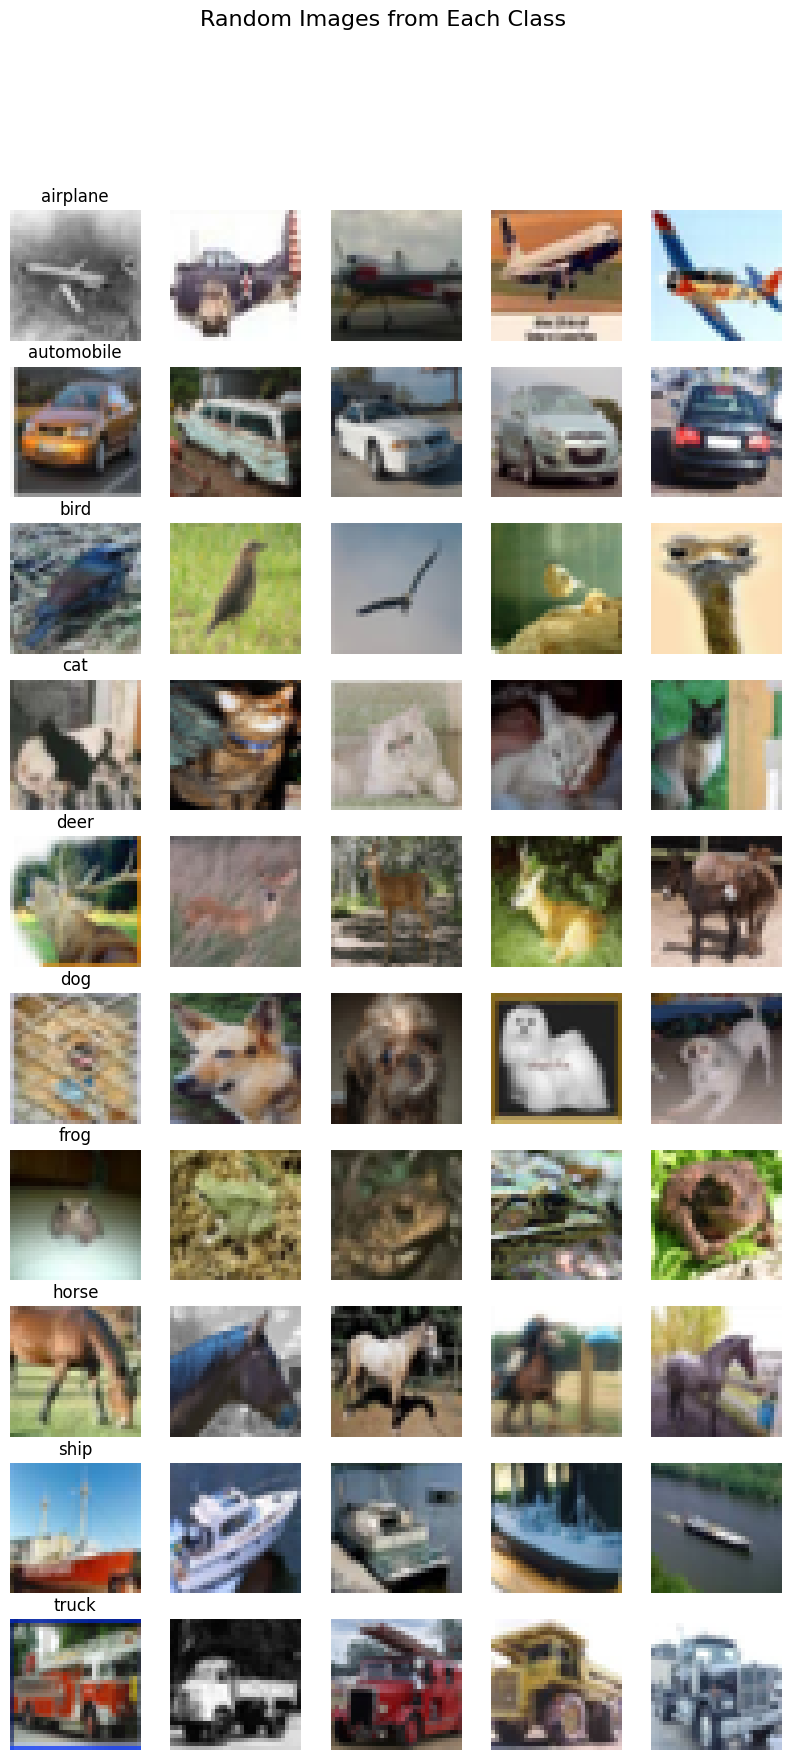

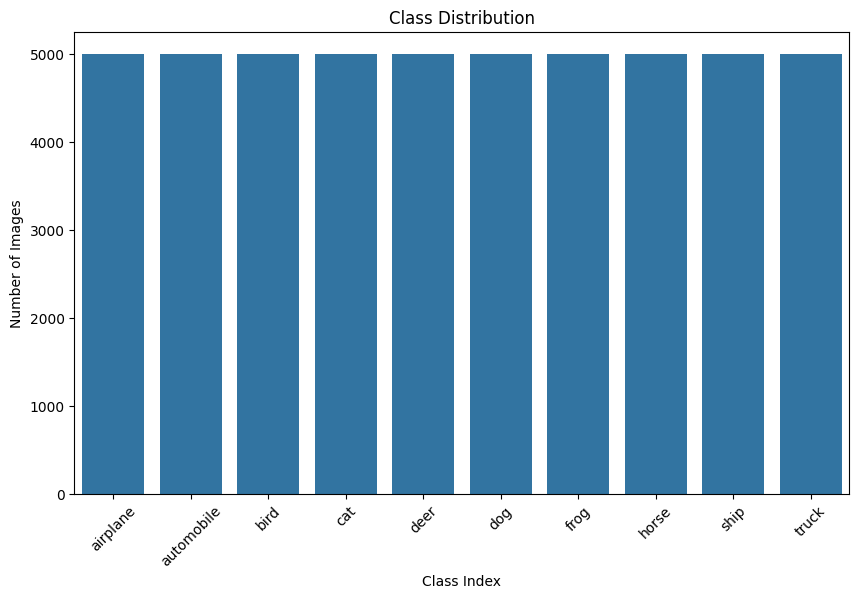

Minimum class: frog with 5000 samples
Maximum class: frog with 5000 samples
Class imbalance ratio: 1.00


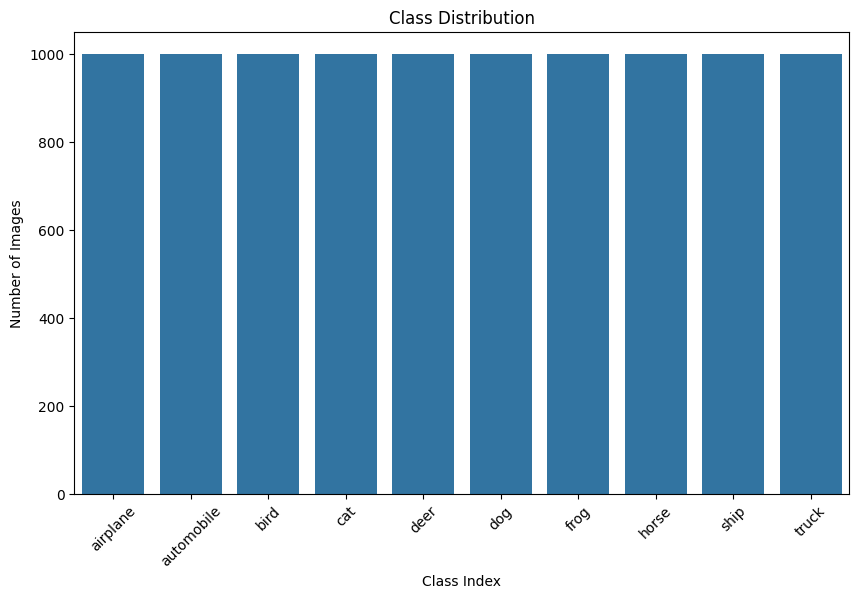

Minimum class: cat with 1000 samples
Maximum class: cat with 1000 samples
Class imbalance ratio: 1.00

Total number of training images: 50000
Total number of test images: 10000
Image shape: torch.Size([3, 32, 32])
Mean: tensor([0.4914, 0.4823, 0.4466])
Std: tensor([0.2022, 0.1991, 0.2006])


In [ ]:
def plot_random_images(dataset, num_images=5):

    fig, axes = plt.subplots(len(class_names), num_images, figsize=(num_images * 2, len(class_names) * 2))
    for idx, class_name in enumerate(class_names):
        class_indices = [i for i, label in enumerate(dataset.targets) if label == idx]
        chosen_indices = np.random.choice(class_indices, num_images, replace=False)

        for j, img_idx in enumerate(chosen_indices):
            image, label = dataset[img_idx]
            axes[idx, j].imshow(image.permute(1, 2, 0))
            axes[idx, j].axis("off")
            if j == 0:
                axes[idx, j].set_title(class_name, fontsize=12)
    plt.suptitle("Random Images from Each Class", fontsize=16)
    plt.show()

def  plot_class_distribuition(dataset):
    # Counting instances per class
    class_counts = Counter(dataset.targets)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
    plt.xlabel("Class Index")
    plt.ylabel("Number of Images")
    plt.title(f"Class Distribution")
    plt.xticks(ticks=np.arange(len(class_names)), labels=class_names, rotation=45)
    plt.show()

    # Display class imbalance details
    min_class, min_count = min(class_counts.items(), key=lambda x: x[1])
    max_class, max_count = max(class_counts.items(), key=lambda x: x[1])
    print(f"Minimum class: {class_names[min_class]} with {min_count} samples")
    print(f"Maximum class: {class_names[max_class]} with {max_count} samples")
    print(f"Class imbalance ratio: {max_count / min_count:.2f}")

plot_random_images(train_data)
plot_class_distribuition(train_data)
plot_class_distribuition(test_data)
# Displaying some statistical information
print(f"\nTotal number of training images: {len(train_data)}")
print(f"Total number of test images: {len(test_data)}")
print(f"Image shape: {train_data[0][0].shape}")

def calculate_mean_std(loader):
    # Initialize sums for mean and std
    mean = 0.0
    std = 0.0
    total_images_count = 0

    for images, _ in loader:
        # Calculate the batch mean and std and add to the running totals
        batch_images_count = images.size(0)
        images = images.view(batch_images_count, images.size(1), -1)  # Flatten height and width
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += batch_images_count

    # Divide by the total number of images to get the average
    mean /= total_images_count
    std /= total_images_count
    return mean, std

mean, std = calculate_mean_std(train_loader)
print(f"Mean: {mean}")
print(f"Std: {std}")

Cifat 10 is a perfefctly balanced Dataset

#Part I

In [ ]:
# Define the baseline CNN model
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        # Fully connected layers
        self.fc1 = nn.Linear(16 * 32 * 32, 256)
        # Dropout with 0.25
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten for fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25, device='cuda'):
    model = model.to(device)
    scaler = GradScaler()
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_acc = 0.0
    best_model = None

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs} [Train]'):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with autocast():  # Improves memory efficiency
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            # Backward pass with gradient
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f'Epoch {epoch + 1}/{num_epochs} [Val]'):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        # Calculate epoch metrics
        epoch_train_loss = train_loss / len(train_loader)
        epoch_train_acc = 100. * train_correct / train_total
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = 100. * val_correct / val_total

        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)

        # Print epoch results
        print(f'\nEpoch {epoch + 1}/{num_epochs}:')
        print(f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%')
        print(f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%')

        # Save best model
        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
            best_model = model.state_dict()

    # Load best model
    if best_model is not None:
        model.load_state_dict(best_model)

    return history, best_acc


def plot_training_curves(results):
    if isinstance(results, tuple):
        results = results[0]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(results['train_loss'], label='Train Loss')
    ax1.plot(results['val_loss'], label='Validation Loss')
    ax1.set_title('Loss Curves')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(results['train_acc'], label='Train Accuracy')
    ax2.plot(results['val_acc'], label='Validation Accuracy')
    ax2.set_title('Accuracy Curves')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()

    plt.tight_layout()
    plt.show()

def evaluate_model(model, test_loader, class_names):
    model.to(device)
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    if class_names is None:
        num_classes = len(np.unique(all_labels))
        class_names = [f'Class {i}' for i in range(num_classes)]

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

Test and Evaluate the Baseline model

In [ ]:
# Hyperparameters and dataset loading
learning_rate = 0.0001
num_epochs = 25

# Model, loss function, and optimizer
BaseModel = CNN()
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(BaseModel.parameters(), lr=learning_rate)

history, best_acc = train_model(BaseModel, train_loader, val_loader, loss, optimizer, num_epochs)

<ipython-input-6-8a866b8947e5>:29: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]<ipython-input-6-8a866b8947e5>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Improves memory efficiency
Epoch 1/25 [Val]: 100%|██████████| 157/157 [00:02<00:00, 54.64it/s]



Epoch 1/25:
Train Loss: 1.9819, Train Acc: 28.36%
Val Loss: 1.7382, Val Acc: 38.89%


Epoch 2/25 [Val]: 100%|██████████| 157/157 [00:02<00:00, 70.77it/s]



Epoch 2/25:
Train Loss: 1.6899, Train Acc: 39.63%
Val Loss: 1.5884, Val Acc: 43.18%


Epoch 3/25 [Val]: 100%|██████████| 157/157 [00:02<00:00, 73.59it/s]



Epoch 3/25:
Train Loss: 1.5734, Train Acc: 43.62%
Val Loss: 1.4983, Val Acc: 46.28%


Epoch 4/25 [Val]: 100%|██████████| 157/157 [00:02<00:00, 66.14it/s]



Epoch 4/25:
Train Loss: 1.5050, Train Acc: 46.14%
Val Loss: 1.4433, Val Acc: 48.24%


Epoch 5/25 [Val]: 100%|██████████| 157/157 [00:02<00:00, 71.41it/s]



Epoch 5/25:
Train Loss: 1.4589, Train Acc: 47.65%
Val Loss: 1.4188, Val Acc: 48.81%


Epoch 6/25 [Val]: 100%|██████████| 157/157 [00:02<00:00, 74.03it/s]



Epoch 6/25:
Train Loss: 1.4209, Train Acc: 48.89%
Val Loss: 1.3778, Val Acc: 50.77%


Epoch 7/25 [Val]: 100%|██████████| 157/157 [00:01<00:00, 84.87it/s]



Epoch 7/25:
Train Loss: 1.3821, Train Acc: 50.42%
Val Loss: 1.3558, Val Acc: 51.62%


Epoch 8/25 [Val]: 100%|██████████| 157/157 [00:01<00:00, 86.50it/s]



Epoch 8/25:
Train Loss: 1.3513, Train Acc: 51.47%
Val Loss: 1.3196, Val Acc: 52.60%


Epoch 9/25 [Val]: 100%|██████████| 157/157 [00:01<00:00, 87.39it/s]



Epoch 9/25:
Train Loss: 1.3250, Train Acc: 52.31%
Val Loss: 1.3221, Val Acc: 52.83%


Epoch 10/25 [Val]: 100%|██████████| 157/157 [00:01<00:00, 86.95it/s]



Epoch 10/25:
Train Loss: 1.3005, Train Acc: 53.36%
Val Loss: 1.2822, Val Acc: 53.81%


Epoch 11/25 [Val]: 100%|██████████| 157/157 [00:01<00:00, 87.53it/s]



Epoch 11/25:
Train Loss: 1.2793, Train Acc: 54.23%
Val Loss: 1.2561, Val Acc: 55.12%


Epoch 12/25 [Val]: 100%|██████████| 157/157 [00:01<00:00, 88.39it/s]



Epoch 12/25:
Train Loss: 1.2554, Train Acc: 55.01%
Val Loss: 1.2444, Val Acc: 55.60%


Epoch 13/25 [Val]: 100%|██████████| 157/157 [00:01<00:00, 85.47it/s]



Epoch 13/25:
Train Loss: 1.2348, Train Acc: 55.73%
Val Loss: 1.2430, Val Acc: 55.31%


Epoch 14/25 [Val]: 100%|██████████| 157/157 [00:01<00:00, 86.92it/s]



Epoch 14/25:
Train Loss: 1.2128, Train Acc: 56.48%
Val Loss: 1.2467, Val Acc: 55.38%


Epoch 15/25 [Val]: 100%|██████████| 157/157 [00:01<00:00, 83.88it/s]



Epoch 15/25:
Train Loss: 1.1926, Train Acc: 57.02%
Val Loss: 1.2093, Val Acc: 56.79%


Epoch 16/25 [Val]: 100%|██████████| 157/157 [00:01<00:00, 86.18it/s]



Epoch 16/25:
Train Loss: 1.1749, Train Acc: 58.17%
Val Loss: 1.2000, Val Acc: 57.08%


Epoch 17/25 [Val]: 100%|██████████| 157/157 [00:01<00:00, 87.11it/s]



Epoch 17/25:
Train Loss: 1.1535, Train Acc: 58.72%
Val Loss: 1.1853, Val Acc: 57.74%


Epoch 18/25 [Val]: 100%|██████████| 157/157 [00:01<00:00, 86.03it/s]



Epoch 18/25:
Train Loss: 1.1370, Train Acc: 59.60%
Val Loss: 1.1784, Val Acc: 58.06%


Epoch 19/25 [Val]: 100%|██████████| 157/157 [00:01<00:00, 85.99it/s]



Epoch 19/25:
Train Loss: 1.1152, Train Acc: 60.14%
Val Loss: 1.1935, Val Acc: 57.60%


Epoch 20/25 [Val]: 100%|██████████| 157/157 [00:01<00:00, 86.51it/s]



Epoch 20/25:
Train Loss: 1.0982, Train Acc: 60.52%
Val Loss: 1.1693, Val Acc: 57.84%


Epoch 21/25 [Val]: 100%|██████████| 157/157 [00:02<00:00, 76.89it/s]



Epoch 21/25:
Train Loss: 1.0829, Train Acc: 61.17%
Val Loss: 1.1604, Val Acc: 58.34%


Epoch 22/25 [Val]: 100%|██████████| 157/157 [00:01<00:00, 87.27it/s]



Epoch 22/25:
Train Loss: 1.0637, Train Acc: 61.86%
Val Loss: 1.1635, Val Acc: 58.48%


Epoch 23/25 [Val]: 100%|██████████| 157/157 [00:01<00:00, 86.41it/s]



Epoch 23/25:
Train Loss: 1.0428, Train Acc: 62.76%
Val Loss: 1.1476, Val Acc: 58.95%


Epoch 24/25 [Val]: 100%|██████████| 157/157 [00:01<00:00, 85.39it/s]



Epoch 24/25:
Train Loss: 1.0275, Train Acc: 63.41%
Val Loss: 1.1384, Val Acc: 59.56%


Epoch 25/25 [Val]: 100%|██████████| 157/157 [00:01<00:00, 86.97it/s]


Epoch 25/25:
Train Loss: 1.0090, Train Acc: 63.89%
Val Loss: 1.1635, Val Acc: 58.96%


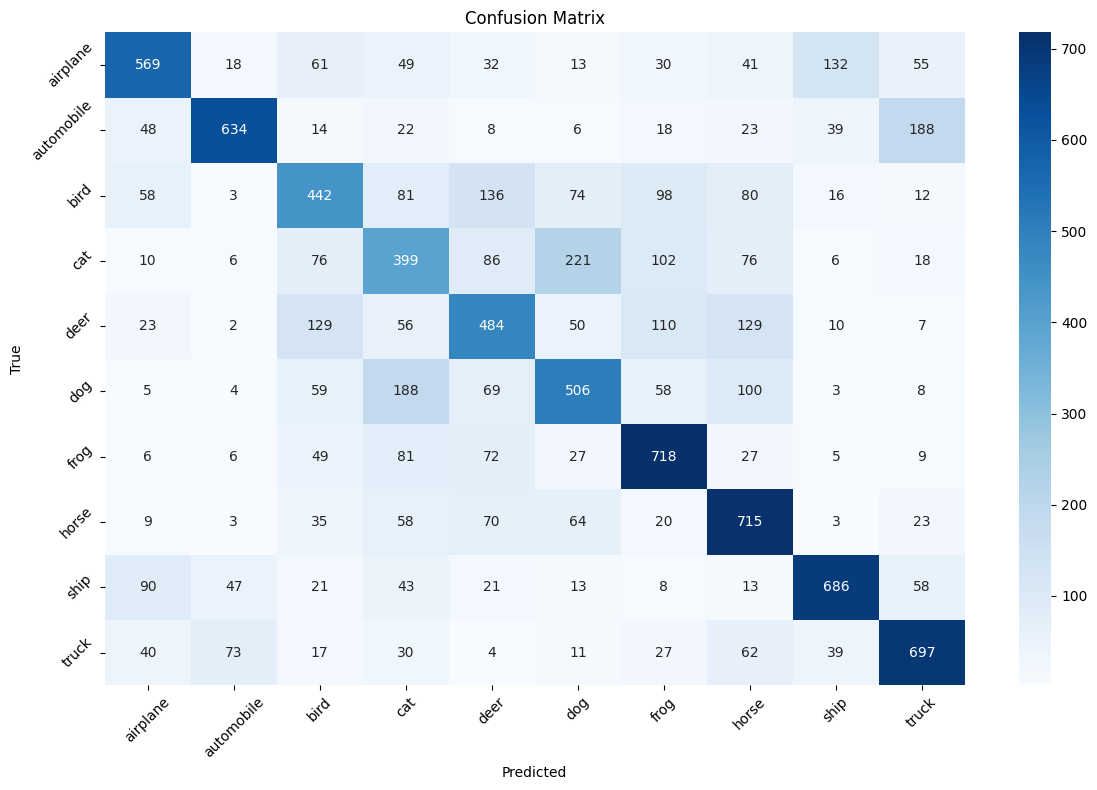


Classification Report:
              precision    recall  f1-score   support

    airplane       0.66      0.57      0.61      1000
  automobile       0.80      0.63      0.71      1000
        bird       0.49      0.44      0.46      1000
         cat       0.40      0.40      0.40      1000
        deer       0.49      0.48      0.49      1000
         dog       0.51      0.51      0.51      1000
        frog       0.60      0.72      0.66      1000
       horse       0.56      0.71      0.63      1000
        ship       0.73      0.69      0.71      1000
       truck       0.65      0.70      0.67      1000

    accuracy                           0.58     10000
   macro avg       0.59      0.58      0.58     10000
weighted avg       0.59      0.58      0.58     10000



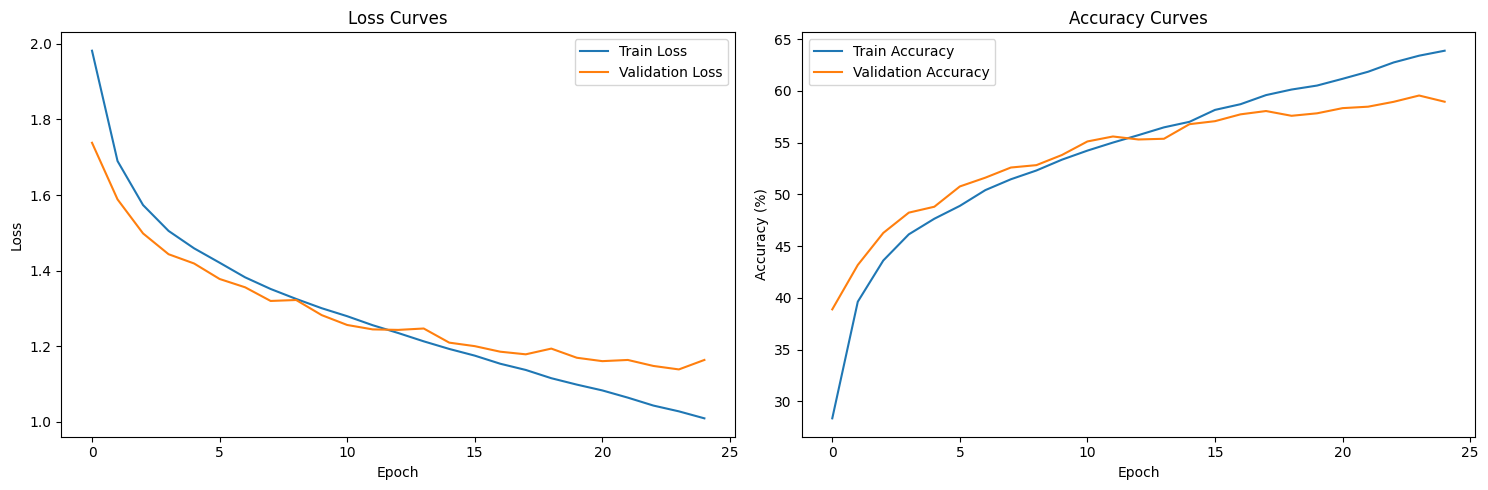

In [ ]:
Cifar10_classes = train_data.classes
evaluate_model(BaseModel, test_loader, Cifar10_classes)
plot_training_curves(history)

gc.collect()
torch.cuda.empty_cache()

In [ ]:
# Print model summary
summary(BaseModel, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             224
            Conv2d-2           [-1, 32, 32, 32]           2,336
            Conv2d-3           [-1, 16, 32, 32]           4,624
            Linear-4                  [-1, 256]       4,194,560
           Dropout-5                  [-1, 256]               0
            Linear-6                   [-1, 64]          16,448
            Linear-7                   [-1, 10]             650
Total params: 4,218,842
Trainable params: 4,218,842
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.44
Params size (MB): 16.09
Estimated Total Size (MB): 16.55
----------------------------------------------------------------


In [ ]:
class CNNV2(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNV2, self).__init__()
        # Convolutional layers  Batch Normalization  Max-Pooling
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Additional Conv layer
        self.bn4 = nn.BatchNorm2d(128)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers with increased Dropout
        self.fc1 = nn.Linear(128 * 2 * 2, 256)  # Adjusted input size based on pooling
        self.dropout = nn.Dropout(0.4)  # Increased dropout rate for better regularization
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool4(torch.relu(self.bn4(self.conv4(x))))

        x = x.view(x.size(0), -1)  # Flatten for fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# Hyperparameters and dataset loading
learning_rate = 0.001
num_epochs = 25

ModelV2 = CNNV2()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ModelV2.parameters(), lr=learning_rate)

history, best_acc_CNNV2 = train_model(ModelV2, train_loader, val_loader, loss, optimizer, num_epochs)


<ipython-input-6-8a866b8947e5>:29: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]<ipython-input-6-8a866b8947e5>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Improves memory efficiency
Epoch 1/25 [Val]: 100%|██████████| 157/157 [00:01<00:00, 90.87it/s]



Epoch 1/25:
Train Loss: 1.4158, Train Acc: 47.36%
Val Loss: 1.2573, Val Acc: 54.54%


Epoch 2/25 [Val]: 100%|██████████| 157/157 [00:01<00:00, 92.21it/s]



Epoch 2/25:
Train Loss: 1.0570, Train Acc: 62.16%
Val Loss: 0.9633, Val Acc: 65.42%


Epoch 3/25 [Val]: 100%|██████████| 157/157 [00:01<00:00, 90.85it/s]



Epoch 3/25:
Train Loss: 0.9053, Train Acc: 68.06%
Val Loss: 0.9323, Val Acc: 66.82%


Epoch 4/25 [Val]: 100%|██████████| 157/157 [00:01<00:00, 91.40it/s]



Epoch 4/25:
Train Loss: 0.7969, Train Acc: 71.91%
Val Loss: 0.8193, Val Acc: 71.47%


Epoch 5/25 [Val]: 100%|██████████| 157/157 [00:01<00:00, 88.39it/s]



Epoch 5/25:
Train Loss: 0.7259, Train Acc: 74.63%
Val Loss: 1.2710, Val Acc: 60.50%


Epoch 6/25 [Val]: 100%|██████████| 157/157 [00:01<00:00, 90.85it/s]



Epoch 6/25:
Train Loss: 0.6573, Train Acc: 77.16%
Val Loss: 0.7516, Val Acc: 73.60%


Epoch 7/25 [Val]: 100%|██████████| 157/157 [00:01<00:00, 92.02it/s]



Epoch 7/25:
Train Loss: 0.5975, Train Acc: 79.04%
Val Loss: 0.8088, Val Acc: 72.97%


Epoch 8/25 [Val]: 100%|██████████| 157/157 [00:01<00:00, 92.08it/s]



Epoch 8/25:
Train Loss: 0.5415, Train Acc: 81.09%
Val Loss: 0.7827, Val Acc: 73.39%


Epoch 9/25 [Val]: 100%|██████████| 157/157 [00:01<00:00, 94.20it/s]



Epoch 9/25:
Train Loss: 0.4973, Train Acc: 82.45%
Val Loss: 0.7303, Val Acc: 76.24%


Epoch 10/25 [Val]: 100%|██████████| 157/157 [00:01<00:00, 92.06it/s]



Epoch 10/25:
Train Loss: 0.4525, Train Acc: 84.06%
Val Loss: 0.7348, Val Acc: 75.68%


Epoch 11/25 [Val]: 100%|██████████| 157/157 [00:01<00:00, 91.22it/s]



Epoch 11/25:
Train Loss: 0.4188, Train Acc: 85.24%
Val Loss: 0.7814, Val Acc: 75.67%


Epoch 12/25 [Val]: 100%|██████████| 157/157 [00:01<00:00, 94.64it/s]



Epoch 12/25:
Train Loss: 0.3792, Train Acc: 86.58%
Val Loss: 0.7823, Val Acc: 74.97%


Epoch 13/25 [Val]: 100%|██████████| 157/157 [00:01<00:00, 91.07it/s]



Epoch 13/25:
Train Loss: 0.3554, Train Acc: 87.62%
Val Loss: 0.8098, Val Acc: 75.06%


Epoch 14/25 [Val]: 100%|██████████| 157/157 [00:01<00:00, 93.04it/s]



Epoch 14/25:
Train Loss: 0.3263, Train Acc: 88.41%
Val Loss: 0.8577, Val Acc: 74.61%


Epoch 15/25 [Val]: 100%|██████████| 157/157 [00:01<00:00, 93.42it/s]



Epoch 15/25:
Train Loss: 0.3035, Train Acc: 89.32%
Val Loss: 0.8994, Val Acc: 75.30%


Epoch 16/25 [Val]: 100%|██████████| 157/157 [00:01<00:00, 91.91it/s]



Epoch 16/25:
Train Loss: 0.2776, Train Acc: 90.11%
Val Loss: 1.0167, Val Acc: 73.79%


Epoch 17/25 [Val]: 100%|██████████| 157/157 [00:01<00:00, 92.33it/s]



Epoch 17/25:
Train Loss: 0.2594, Train Acc: 90.73%
Val Loss: 0.9216, Val Acc: 75.04%


Epoch 18/25 [Val]: 100%|██████████| 157/157 [00:01<00:00, 93.11it/s]



Epoch 18/25:
Train Loss: 0.2351, Train Acc: 91.69%
Val Loss: 1.0428, Val Acc: 73.17%


Epoch 19/25 [Val]: 100%|██████████| 157/157 [00:01<00:00, 92.29it/s]



Epoch 19/25:
Train Loss: 0.2199, Train Acc: 92.23%
Val Loss: 1.0085, Val Acc: 74.74%


Epoch 20/25 [Val]: 100%|██████████| 157/157 [00:02<00:00, 75.05it/s]



Epoch 20/25:
Train Loss: 0.2153, Train Acc: 92.44%
Val Loss: 1.0781, Val Acc: 74.19%


Epoch 21/25 [Val]: 100%|██████████| 157/157 [00:02<00:00, 76.05it/s]



Epoch 21/25:
Train Loss: 0.1960, Train Acc: 93.08%
Val Loss: 0.9932, Val Acc: 76.18%


Epoch 22/25 [Val]: 100%|██████████| 157/157 [00:02<00:00, 70.42it/s]



Epoch 22/25:
Train Loss: 0.1829, Train Acc: 93.61%
Val Loss: 1.1125, Val Acc: 73.74%


Epoch 23/25 [Val]: 100%|██████████| 157/157 [00:02<00:00, 64.20it/s]



Epoch 23/25:
Train Loss: 0.1864, Train Acc: 93.38%
Val Loss: 1.1250, Val Acc: 74.84%


Epoch 24/25 [Val]: 100%|██████████| 157/157 [00:02<00:00, 66.53it/s]



Epoch 24/25:
Train Loss: 0.1653, Train Acc: 94.31%
Val Loss: 1.0235, Val Acc: 74.85%


Epoch 25/25 [Val]: 100%|██████████| 157/157 [00:02<00:00, 65.07it/s]


Epoch 25/25:
Train Loss: 0.1580, Train Acc: 94.40%
Val Loss: 1.1435, Val Acc: 74.71%


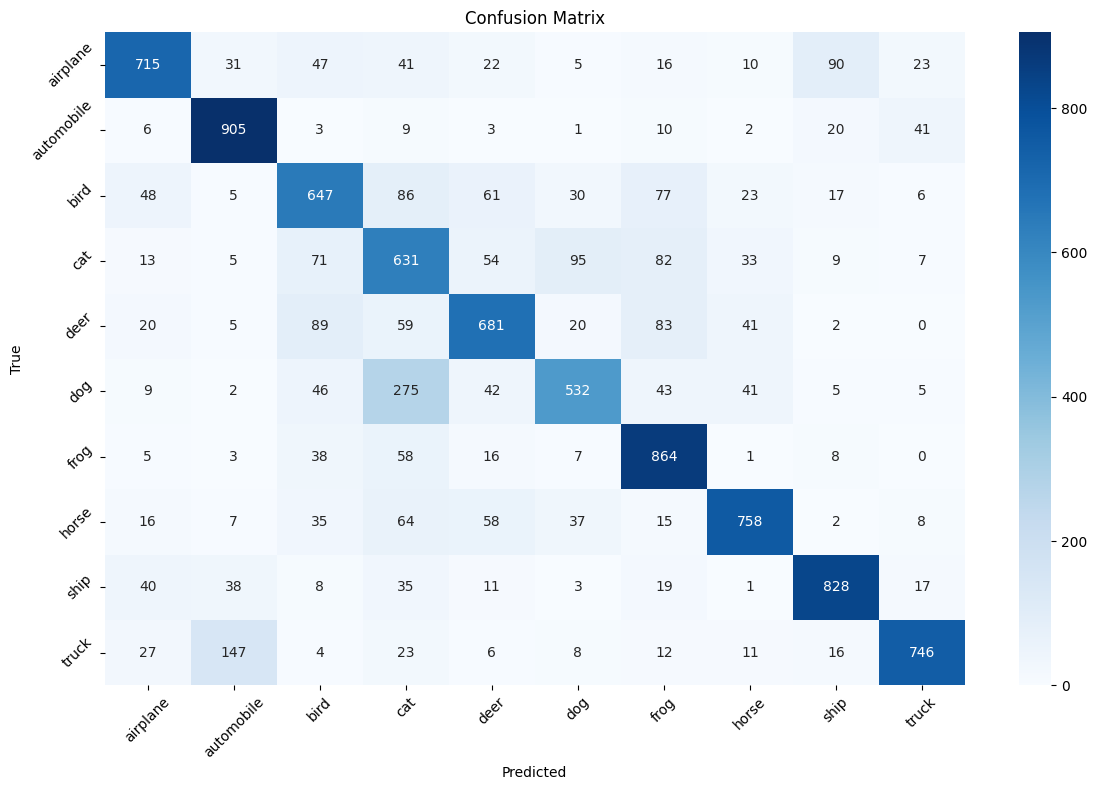


Classification Report:
              precision    recall  f1-score   support

    airplane       0.80      0.71      0.75      1000
  automobile       0.79      0.91      0.84      1000
        bird       0.65      0.65      0.65      1000
         cat       0.49      0.63      0.55      1000
        deer       0.71      0.68      0.70      1000
         dog       0.72      0.53      0.61      1000
        frog       0.71      0.86      0.78      1000
       horse       0.82      0.76      0.79      1000
        ship       0.83      0.83      0.83      1000
       truck       0.87      0.75      0.81      1000

    accuracy                           0.73     10000
   macro avg       0.74      0.73      0.73     10000
weighted avg       0.74      0.73      0.73     10000



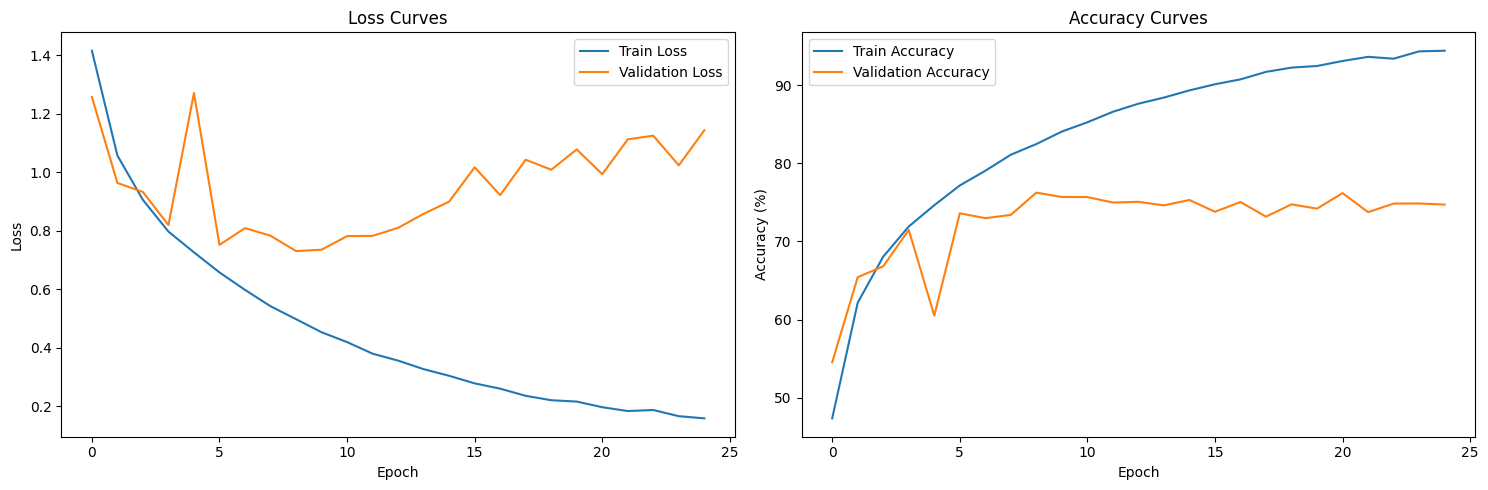

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
         MaxPool2d-3           [-1, 16, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]           4,640
       BatchNorm2d-5           [-1, 32, 16, 16]              64
         MaxPool2d-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 64, 8, 8]          18,496
       BatchNorm2d-8             [-1, 64, 8, 8]             128
         MaxPool2d-9             [-1, 64, 4, 4]               0
           Conv2d-10            [-1, 128, 4, 4]          73,856
      BatchNorm2d-11            [-1, 128, 4, 4]             256
        MaxPool2d-12            [-1, 128, 2, 2]               0
           Linear-13                  [-1, 256]         131,328
          Dropout-14                  [

In [ ]:
Cifar10_classes = train_data.classes
evaluate_model(ModelV2, test_loader, Cifar10_classes)
plot_training_curves(history)

# Print model summary
summary(ModelV2, input_size=(3, 32, 32))

gc.collect()
torch.cuda.empty_cache()

In [ ]:
class CNNV3(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNV3, self).__init__()

        # First convolutional block
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.2)

        # Second convolutional block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.3)

        # Third convolutional block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(0.4)

        # Fourth convolutional block
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout4 = nn.Dropout(0.5)

        # Fifth convolutional block (newly added)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout5 = nn.Dropout(0.5)

        # Fully connected layer
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(512 * 1 * 1, num_classes)  #

    def forward(self, x):
        # First convolutional block
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = self.dropout1(x)

        # Second convolutional block
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = self.dropout2(x)

        # Third convolutional block
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = self.dropout3(x)

        # Fourth convolutional block
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool4(x)
        x = self.dropout4(x)

        # Fifth convolutional block (newly added)
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool5(x)
        x = self.dropout5(x)

        # Fully connected layer
        x = self.flatten(x)
        x = self.fc(x)

        return x

In [ ]:
#Data Augmentation
data_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),                           # Horizontal flip
    transforms.RandomRotation(15),                               # Randomly rotate image within ±15 degrees
    transforms.RandomAffine(degrees=0,                           # Affine transform to apply width and height shift
                            translate=(0.12, 0.12)),             # Shift up to 12% of width/height
    transforms.RandomAffine(degrees=0,                           # Affine transform to apply zoom
                            scale=(0.9, 1.1)),                   # Zoom within 90% to 110% of original size
    transforms.ColorJitter(brightness=(0.9, 1.1)),               # Adjust brightness within 90% to 110%
    transforms.RandomAffine(degrees=10, shear=10),               # Apply shear within ±10 degrees
    transforms.RandomApply([transforms.ColorJitter(              # Channel shift by randomly adjusting brightness,
                        brightness=0.1, contrast=0.1,            # contrast, and saturation slightly
                        saturation=0.1, hue=0.1)], p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4823, 0.4466), (0.2022, 0.1991, 0.2006))  # Normalize based on CIFAR-10 stats
])

train_data = CIFAR10(root=data_path, train=True, download=download, transform=data_transform)

train_sampler = SubsetRandomSampler(train_indices)

train_loader_augmented = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)

# Hyperparameters and dataset loading
learning_rate = 0.001
weight_decay=0.0001
num_epochs = 25


ModelV3 = CNNV3()
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(ModelV3.parameters(), lr=learning_rate, weight_decay=weight_decay)

history, best_acc_CNNV = train_model(ModelV3, train_loader, val_loader, loss, optimizer, num_epochs)

Files already downloaded and verified


<ipython-input-6-8a866b8947e5>:29: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]<ipython-input-6-8a866b8947e5>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Improves memory efficiency
Epoch 1/25 [Val]: 100%|██████████| 157/157 [00:01<00:00, 80.75it/s]



Epoch 1/25:
Train Loss: 1.6062, Train Acc: 41.25%
Val Loss: 1.3147, Val Acc: 52.21%


Epoch 2/25 [Val]: 100%|██████████| 157/157 [00:01<00:00, 80.46it/s]



Epoch 2/25:
Train Loss: 1.2525, Train Acc: 54.61%
Val Loss: 1.1236, Val Acc: 59.44%


Epoch 3/25 [Val]: 100%|██████████| 157/157 [00:02<00:00, 71.76it/s]



Epoch 3/25:
Train Loss: 1.1237, Train Acc: 59.94%
Val Loss: 1.2849, Val Acc: 52.80%


Epoch 4/25 [Val]: 100%|██████████| 157/157 [00:02<00:00, 70.04it/s]



Epoch 4/25:
Train Loss: 1.0351, Train Acc: 63.33%
Val Loss: 1.0227, Val Acc: 63.43%


Epoch 5/25 [Val]: 100%|██████████| 157/157 [00:02<00:00, 64.18it/s]



Epoch 5/25:
Train Loss: 0.9749, Train Acc: 65.47%
Val Loss: 0.8158, Val Acc: 71.21%


Epoch 6/25 [Val]: 100%|██████████| 157/157 [00:02<00:00, 75.31it/s]



Epoch 6/25:
Train Loss: 0.9198, Train Acc: 67.57%
Val Loss: 0.9847, Val Acc: 65.34%


Epoch 7/25 [Val]: 100%|██████████| 157/157 [00:01<00:00, 81.09it/s]



Epoch 7/25:
Train Loss: 0.8827, Train Acc: 68.84%
Val Loss: 0.7862, Val Acc: 71.50%


Epoch 8/25 [Val]: 100%|██████████| 157/157 [00:01<00:00, 87.08it/s]



Epoch 8/25:
Train Loss: 0.8464, Train Acc: 70.23%
Val Loss: 0.7294, Val Acc: 74.44%


Epoch 9/25 [Val]: 100%|██████████| 157/157 [00:01<00:00, 85.09it/s]



Epoch 9/25:
Train Loss: 0.8286, Train Acc: 70.99%
Val Loss: 0.7057, Val Acc: 75.68%


Epoch 10/25 [Val]: 100%|██████████| 157/157 [00:01<00:00, 87.00it/s]



Epoch 10/25:
Train Loss: 0.8018, Train Acc: 71.96%
Val Loss: 0.7383, Val Acc: 73.23%


Epoch 11/25 [Val]: 100%|██████████| 157/157 [00:01<00:00, 86.38it/s]



Epoch 11/25:
Train Loss: 0.7748, Train Acc: 72.86%
Val Loss: 0.9688, Val Acc: 66.63%


Epoch 12/25 [Val]: 100%|██████████| 157/157 [00:01<00:00, 86.41it/s]



Epoch 12/25:
Train Loss: 0.7667, Train Acc: 73.22%
Val Loss: 0.6498, Val Acc: 77.76%


Epoch 13/25 [Val]: 100%|██████████| 157/157 [00:01<00:00, 86.91it/s]



Epoch 13/25:
Train Loss: 0.7438, Train Acc: 73.88%
Val Loss: 0.6947, Val Acc: 75.17%


Epoch 14/25 [Val]: 100%|██████████| 157/157 [00:01<00:00, 87.50it/s]



Epoch 14/25:
Train Loss: 0.7380, Train Acc: 74.33%
Val Loss: 0.7878, Val Acc: 72.97%


Epoch 15/25 [Val]: 100%|██████████| 157/157 [00:01<00:00, 86.71it/s]



Epoch 15/25:
Train Loss: 0.7182, Train Acc: 74.77%
Val Loss: 0.7601, Val Acc: 73.63%


Epoch 16/25 [Val]: 100%|██████████| 157/157 [00:02<00:00, 64.72it/s]



Epoch 16/25:
Train Loss: 0.7078, Train Acc: 75.41%
Val Loss: 0.6517, Val Acc: 76.94%


Epoch 17/25 [Val]: 100%|██████████| 157/157 [00:01<00:00, 86.94it/s]



Epoch 17/25:
Train Loss: 0.6969, Train Acc: 75.67%
Val Loss: 0.7037, Val Acc: 75.62%


Epoch 18/25 [Val]: 100%|██████████| 157/157 [00:01<00:00, 86.86it/s]



Epoch 18/25:
Train Loss: 0.6879, Train Acc: 76.24%
Val Loss: 0.6285, Val Acc: 78.12%


Epoch 19/25 [Val]: 100%|██████████| 157/157 [00:01<00:00, 88.48it/s]



Epoch 19/25:
Train Loss: 0.6767, Train Acc: 76.42%
Val Loss: 0.6051, Val Acc: 79.55%


Epoch 20/25 [Val]: 100%|██████████| 157/157 [00:01<00:00, 87.49it/s]



Epoch 20/25:
Train Loss: 0.6789, Train Acc: 76.32%
Val Loss: 0.7293, Val Acc: 73.98%


Epoch 21/25 [Val]: 100%|██████████| 157/157 [00:01<00:00, 87.64it/s]



Epoch 21/25:
Train Loss: 0.6696, Train Acc: 76.64%
Val Loss: 0.6536, Val Acc: 76.94%


Epoch 22/25 [Val]: 100%|██████████| 157/157 [00:01<00:00, 87.04it/s]



Epoch 22/25:
Train Loss: 0.6595, Train Acc: 77.16%
Val Loss: 0.6786, Val Acc: 76.44%


Epoch 23/25 [Val]: 100%|██████████| 157/157 [00:01<00:00, 86.30it/s]



Epoch 23/25:
Train Loss: 0.6541, Train Acc: 77.11%
Val Loss: 0.6201, Val Acc: 78.47%


Epoch 24/25 [Val]: 100%|██████████| 157/157 [00:01<00:00, 82.97it/s]



Epoch 24/25:
Train Loss: 0.6483, Train Acc: 77.40%
Val Loss: 0.5696, Val Acc: 80.27%


Epoch 25/25 [Val]: 100%|██████████| 157/157 [00:01<00:00, 79.32it/s]


Epoch 25/25:
Train Loss: 0.6470, Train Acc: 77.57%
Val Loss: 0.5908, Val Acc: 79.32%


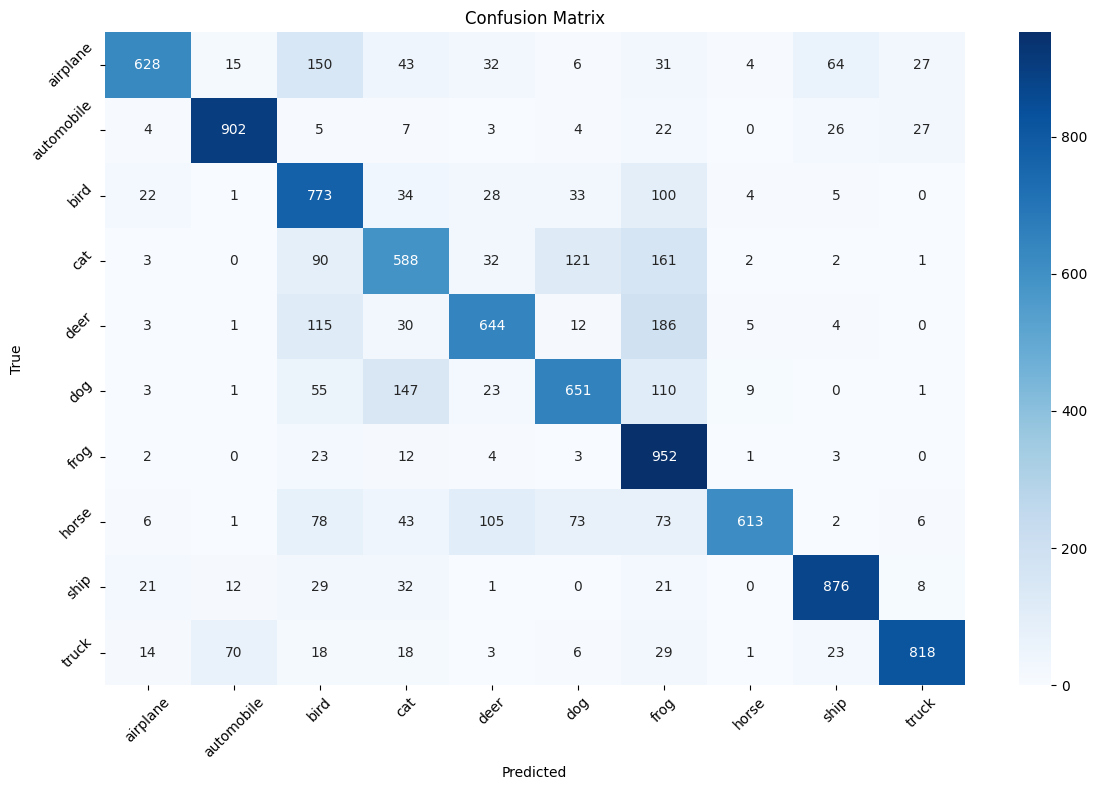


Classification Report:
              precision    recall  f1-score   support

    airplane       0.89      0.63      0.74      1000
  automobile       0.90      0.90      0.90      1000
        bird       0.58      0.77      0.66      1000
         cat       0.62      0.59      0.60      1000
        deer       0.74      0.64      0.69      1000
         dog       0.72      0.65      0.68      1000
        frog       0.56      0.95      0.71      1000
       horse       0.96      0.61      0.75      1000
        ship       0.87      0.88      0.87      1000
       truck       0.92      0.82      0.87      1000

    accuracy                           0.74     10000
   macro avg       0.78      0.74      0.75     10000
weighted avg       0.78      0.74      0.75     10000



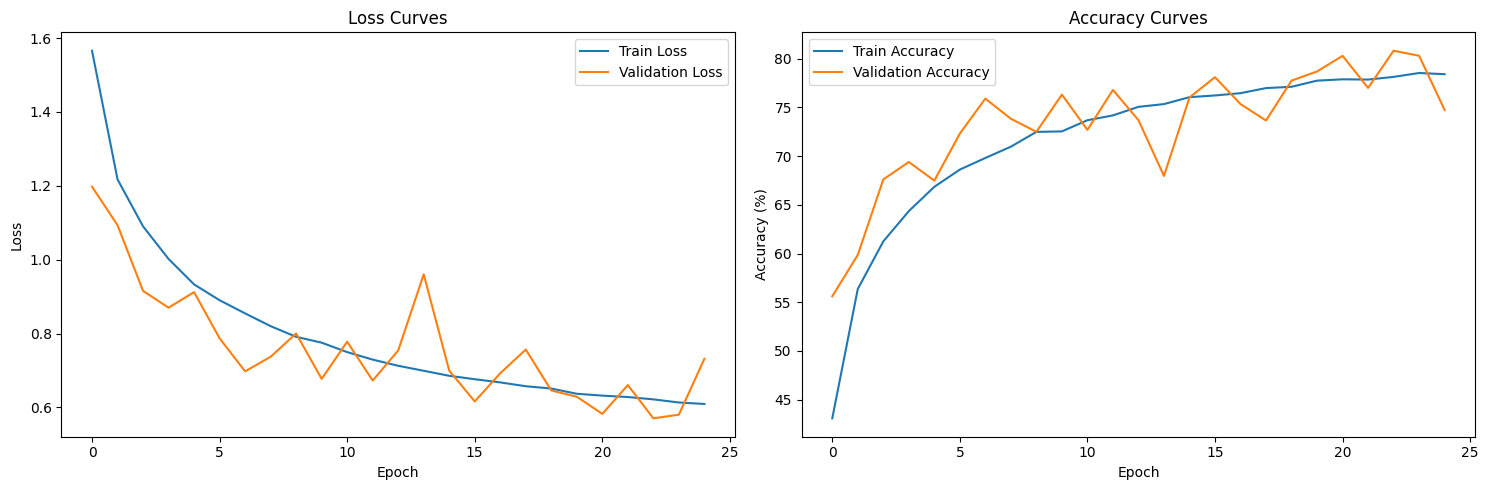

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
         MaxPool2d-3           [-1, 32, 16, 16]               0
           Dropout-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,432
       BatchNorm2d-6           [-1, 64, 16, 16]             128
         MaxPool2d-7             [-1, 64, 8, 8]               0
           Dropout-8             [-1, 64, 8, 8]               0
            Conv2d-9            [-1, 128, 8, 8]          73,728
      BatchNorm2d-10            [-1, 128, 8, 8]             256
        MaxPool2d-11            [-1, 128, 4, 4]               0
          Dropout-12            [-1, 128, 4, 4]               0
           Conv2d-13            [-1, 256, 4, 4]         294,912
      BatchNorm2d-14            [-1, 25

In [ ]:
Cifar10_classes = train_data.classes
evaluate_model(ModelV3, test_loader, Cifar10_classes)
plot_training_curves(history)

# Print model summary
summary(ModelV3, input_size=(3, 32, 32))

gc.collect()
torch.cuda.empty_cache()

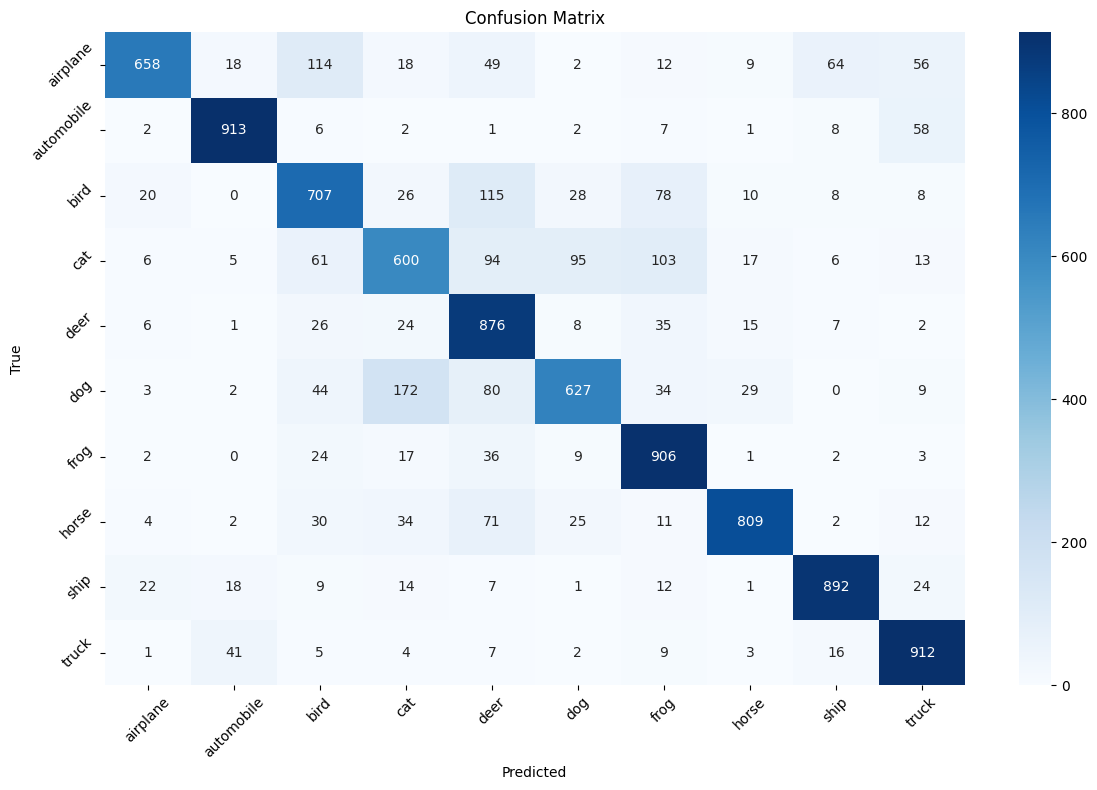


Classification Report:
              precision    recall  f1-score   support

    airplane       0.91      0.66      0.76      1000
  automobile       0.91      0.91      0.91      1000
        bird       0.69      0.71      0.70      1000
         cat       0.66      0.60      0.63      1000
        deer       0.66      0.88      0.75      1000
         dog       0.78      0.63      0.70      1000
        frog       0.75      0.91      0.82      1000
       horse       0.90      0.81      0.85      1000
        ship       0.89      0.89      0.89      1000
       truck       0.83      0.91      0.87      1000

    accuracy                           0.79     10000
   macro avg       0.80      0.79      0.79     10000
weighted avg       0.80      0.79      0.79     10000



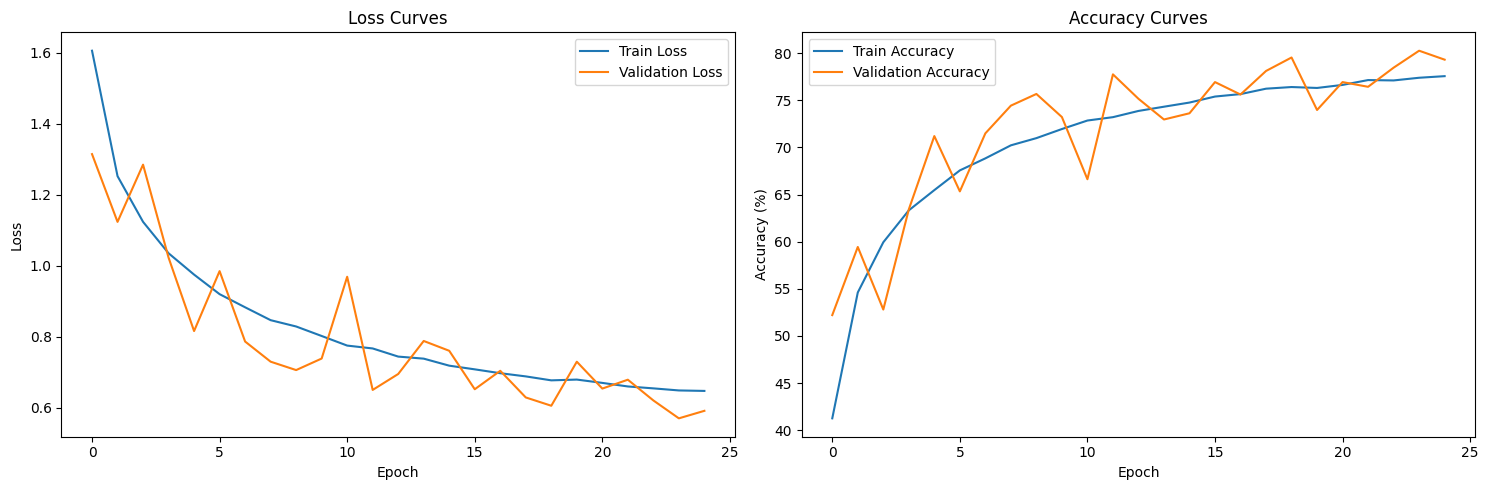

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
         MaxPool2d-3           [-1, 32, 16, 16]               0
           Dropout-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,432
       BatchNorm2d-6           [-1, 64, 16, 16]             128
         MaxPool2d-7             [-1, 64, 8, 8]               0
           Dropout-8             [-1, 64, 8, 8]               0
            Conv2d-9            [-1, 128, 8, 8]          73,728
      BatchNorm2d-10            [-1, 128, 8, 8]             256
        MaxPool2d-11            [-1, 128, 4, 4]               0
          Dropout-12            [-1, 128, 4, 4]               0
           Conv2d-13            [-1, 256, 4, 4]         294,912
      BatchNorm2d-14            [-1, 25

In [ ]:
Cifar10_classes = train_data.classes
evaluate_model(ModelV3, test_loader, Cifar10_classes)
plot_training_curves(history)

# Print model summary
summary(ModelV3, input_size=(3, 32, 32))

gc.collect()
torch.cuda.empty_cache()

In [ ]:
# Definir as diferentes combinações de hiperparâmetros
hyperparameter_configs = [
    {"learning_rate": 0.001, "dropout": 0.3, "weight_decay": 0.0001},
    {"learning_rate": 0.0005, "dropout": 0.4, "weight_decay": 0.0005},
    {"learning_rate": 0.0001, "dropout": 0.3, "weight_decay": 0.0001},
    {"learning_rate": 0.0001, "dropout": 0.5, "weight_decay": 0.0005}
]

## Part II

In [ ]:
# Define transforms for the dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_2 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load dataset
dataset = EuroSAT(download=True, root="./data", transform=transform)
dataset_2 = EuroSAT(download=True, root="./data", transform=transform_2)
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size


train_data, test_data = random_split(dataset, [train_size, test_size])


train_size = int(len(train_data) * 0.9)
val_size = len(train_data) - train_size

train_data, val_data = random_split(train_data, [train_size, val_size])


train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=4)


Number of classes: 10
Class names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


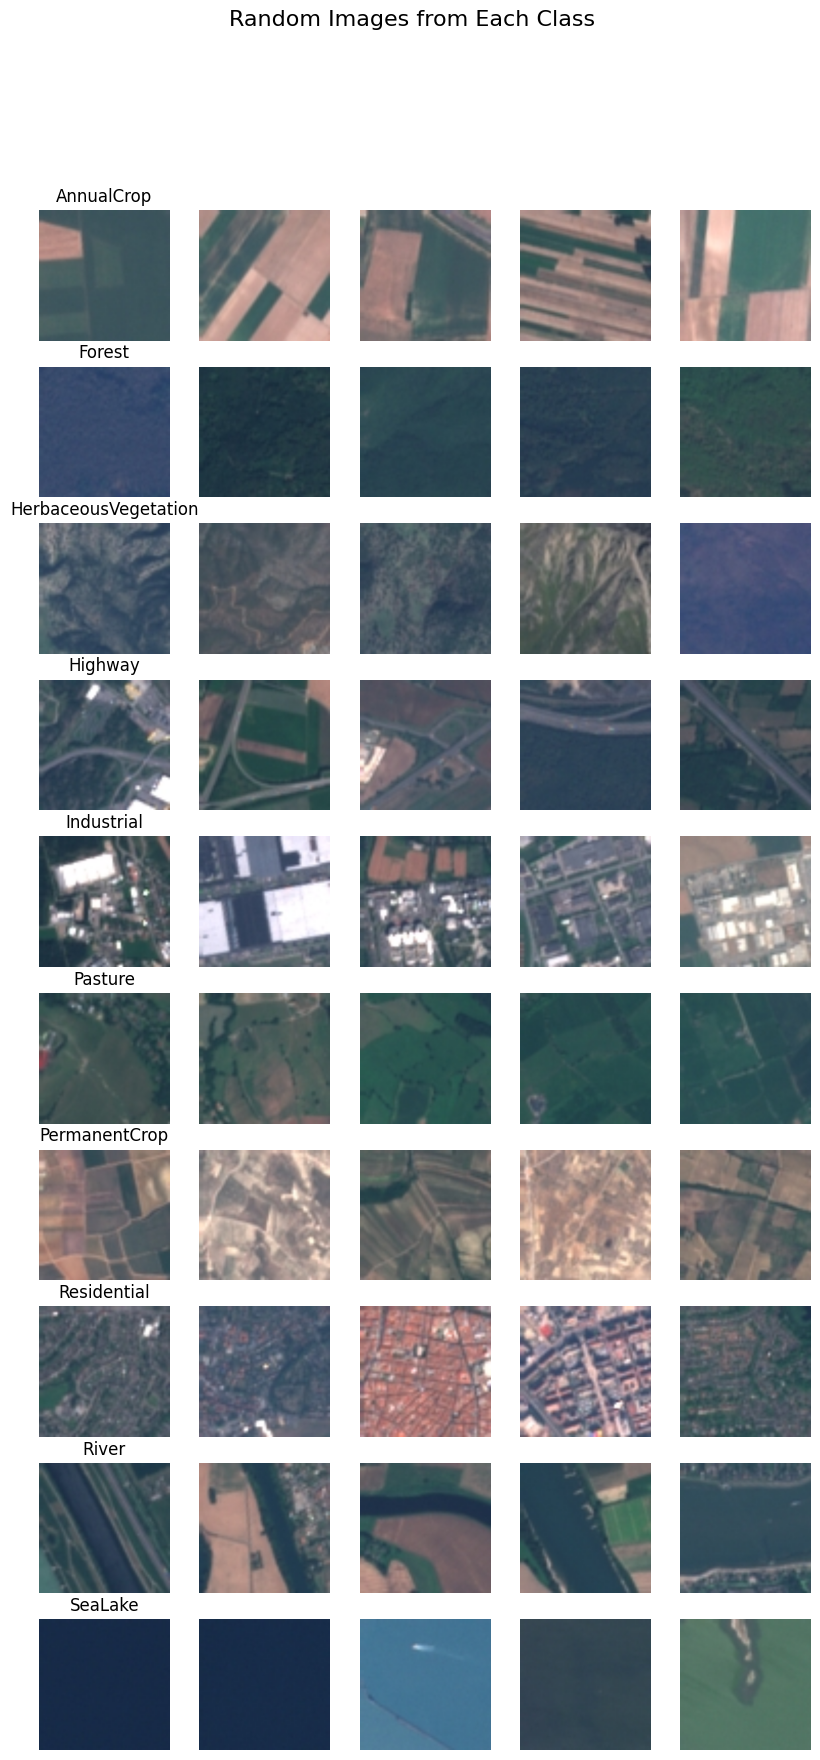

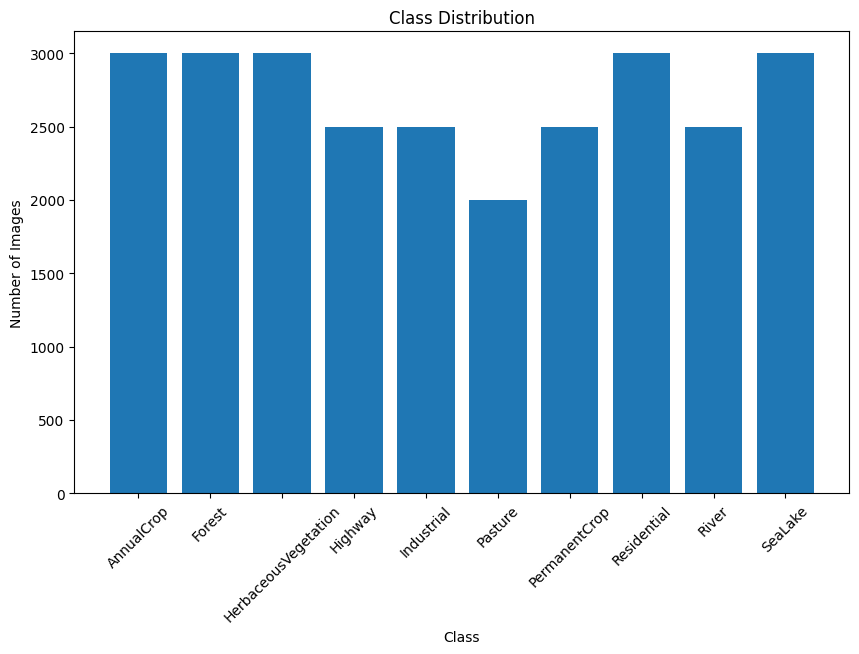

Minimum class: Pasture with 2000 samples
Maximum class: AnnualCrop with 3000 samples
Class imbalance ratio: 1.50

Total number of training images: 19440
Total number of test images: 169
Image shape: torch.Size([3, 224, 224])


In [ ]:
class_names = dataset_2.classes
num_classes = len(class_names)

print(f"Number of classes: {num_classes}")
print("Class names:", class_names)

# Plot random images from each class
fig, axes = plt.subplots(len(dataset_2.classes), 5, figsize=(10, len(dataset_2.classes) * 2))
for idx, class_name in enumerate(dataset_2.classes):
    class_indices = [i for i, label in enumerate(dataset_2.targets) if label == idx]
    chosen_indices = np.random.choice(class_indices, 5, replace=False)
    for j, img_idx in enumerate(chosen_indices):
        image, label = dataset_2[img_idx]
        image = (image * 255).to(torch.uint8)  # Scale pixel values back to [0, 255]
        axes[idx, j].imshow(image.permute(1, 2, 0))
        axes[idx, j].axis("off")
        if j == 0:
            axes[idx, j].set_title(class_name, fontsize=12)
plt.suptitle("Random Images from Each Class", fontsize=16)
plt.show()

# Plot class distribution
plt.figure(figsize=(10, 6))
plt.bar(dataset.classes, Counter(dataset.targets).values())
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.show()

# Display class imbalance details
class_counts = Counter(dataset.targets)
min_class, min_count = min(class_counts.items(), key=lambda x: x[1])
max_class, max_count = max(class_counts.items(), key=lambda x: x[1])
print(f"Minimum class: {dataset.classes[min_class]} with {min_count} samples")
print(f"Maximum class: {dataset.classes[max_class]} with {max_count} samples")
print(f"Class imbalance ratio: {max_count / min_count:.2f}")

# Displaying some statistical information
print(f"\nTotal number of training images: {len(train_data)}")
print(f"Total number of test images: {len(test_loader)}")
print(f"Image shape: {train_data[0][0].shape}")

Training AlexNet from Scratch

C:\Users\leole\AppData\Local\Temp\ipykernel_22972\1289117308.py:30: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/25 [Train]:   0%|          | 0/675 [00:00<?, ?it/s]C:\Users\leole\AppData\Local\Temp\ipykernel_22972\1289117308.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Improves memory efficiency
Epoch 1/25 [Val]: 100%|██████████| 169/169 [00:16<00:00, 10.06it/s]



Epoch 1/25:
Train Loss: 1.6434, Train Acc: 35.19%
Val Loss: 1.1791, Val Acc: 54.54%


Epoch 2/25 [Val]: 100%|██████████| 169/169 [00:17<00:00,  9.82it/s]



Epoch 2/25:
Train Loss: 1.1444, Train Acc: 57.63%
Val Loss: 0.8802, Val Acc: 68.63%


Epoch 3/25 [Val]: 100%|██████████| 169/169 [00:16<00:00, 10.10it/s]



Epoch 3/25:
Train Loss: 0.9379, Train Acc: 66.67%
Val Loss: 0.8265, Val Acc: 69.52%


Epoch 4/25 [Val]: 100%|██████████| 169/169 [00:16<00:00, 10.31it/s]



Epoch 4/25:
Train Loss: 0.8447, Train Acc: 69.73%
Val Loss: 0.7162, Val Acc: 74.56%


Epoch 5/25 [Val]: 100%|██████████| 169/169 [00:16<00:00, 10.26it/s]



Epoch 5/25:
Train Loss: 0.7789, Train Acc: 72.91%
Val Loss: 0.6482, Val Acc: 77.74%


Epoch 6/25 [Val]: 100%|██████████| 169/169 [00:16<00:00, 10.17it/s]



Epoch 6/25:
Train Loss: 0.7229, Train Acc: 74.66%
Val Loss: 0.6450, Val Acc: 76.83%


Epoch 7/25 [Val]: 100%|██████████| 169/169 [00:16<00:00, 10.12it/s]



Epoch 7/25:
Train Loss: 0.7089, Train Acc: 74.82%
Val Loss: 0.6857, Val Acc: 75.83%


Epoch 8/25 [Val]: 100%|██████████| 169/169 [00:16<00:00, 10.22it/s]



Epoch 8/25:
Train Loss: 0.6576, Train Acc: 76.46%
Val Loss: 0.6196, Val Acc: 78.85%


Epoch 9/25 [Val]: 100%|██████████| 169/169 [00:16<00:00, 10.04it/s]



Epoch 9/25:
Train Loss: 0.6174, Train Acc: 78.46%
Val Loss: 0.6056, Val Acc: 79.93%


Epoch 10/25 [Val]: 100%|██████████| 169/169 [00:17<00:00,  9.67it/s]



Epoch 10/25:
Train Loss: 0.7646, Train Acc: 73.64%
Val Loss: 0.5689, Val Acc: 80.22%


Epoch 11/25 [Val]: 100%|██████████| 169/169 [00:17<00:00,  9.63it/s]



Epoch 11/25:
Train Loss: 0.6098, Train Acc: 78.79%
Val Loss: 0.5777, Val Acc: 80.65%


Epoch 12/25 [Val]: 100%|██████████| 169/169 [00:16<00:00, 10.43it/s]



Epoch 12/25:
Train Loss: 0.5627, Train Acc: 79.84%
Val Loss: 0.5307, Val Acc: 81.61%


Epoch 13/25 [Val]: 100%|██████████| 169/169 [00:16<00:00, 10.37it/s]



Epoch 13/25:
Train Loss: 0.5381, Train Acc: 81.12%
Val Loss: 0.5338, Val Acc: 81.91%


Epoch 14/25 [Val]: 100%|██████████| 169/169 [00:16<00:00, 10.35it/s]



Epoch 14/25:
Train Loss: 0.5505, Train Acc: 80.87%
Val Loss: 0.5563, Val Acc: 82.20%


Epoch 15/25 [Val]: 100%|██████████| 169/169 [00:16<00:00, 10.46it/s]



Epoch 15/25:
Train Loss: 0.5228, Train Acc: 81.69%
Val Loss: 0.6193, Val Acc: 79.93%


Epoch 16/25 [Val]: 100%|██████████| 169/169 [00:16<00:00, 10.18it/s]



Epoch 16/25:
Train Loss: 0.5256, Train Acc: 81.70%
Val Loss: 0.5608, Val Acc: 80.80%


Epoch 17/25 [Val]: 100%|██████████| 169/169 [00:16<00:00, 10.31it/s]



Epoch 17/25:
Train Loss: 0.4948, Train Acc: 82.88%
Val Loss: 0.5473, Val Acc: 81.85%


Epoch 18/25 [Val]: 100%|██████████| 169/169 [00:16<00:00, 10.30it/s]



Epoch 18/25:
Train Loss: 0.4744, Train Acc: 83.55%
Val Loss: 0.5340, Val Acc: 82.22%


Epoch 19/25 [Val]: 100%|██████████| 169/169 [00:16<00:00, 10.27it/s]



Epoch 19/25:
Train Loss: 0.4905, Train Acc: 83.05%
Val Loss: 0.5175, Val Acc: 82.50%


Epoch 20/25 [Val]: 100%|██████████| 169/169 [00:16<00:00, 10.49it/s]



Epoch 20/25:
Train Loss: 0.4864, Train Acc: 83.12%
Val Loss: 0.5456, Val Acc: 81.46%


Epoch 21/25 [Val]: 100%|██████████| 169/169 [00:16<00:00, 10.48it/s]



Epoch 21/25:
Train Loss: 0.4751, Train Acc: 83.75%
Val Loss: 0.6132, Val Acc: 79.98%


Epoch 22/25 [Val]: 100%|██████████| 169/169 [00:16<00:00, 10.48it/s]



Epoch 22/25:
Train Loss: 0.4423, Train Acc: 84.77%
Val Loss: 0.5218, Val Acc: 83.15%


Epoch 23/25 [Val]: 100%|██████████| 169/169 [00:16<00:00, 10.53it/s]



Epoch 23/25:
Train Loss: 0.4478, Train Acc: 84.40%
Val Loss: 0.5440, Val Acc: 81.69%


Epoch 24/25 [Val]: 100%|██████████| 169/169 [00:17<00:00,  9.42it/s]



Epoch 24/25:
Train Loss: 0.4237, Train Acc: 85.41%
Val Loss: 0.6025, Val Acc: 80.96%


Epoch 25/25 [Val]: 100%|██████████| 169/169 [00:17<00:00,  9.55it/s]



Epoch 25/25:
Train Loss: 0.4185, Train Acc: 85.44%
Val Loss: 0.5464, Val Acc: 82.63%


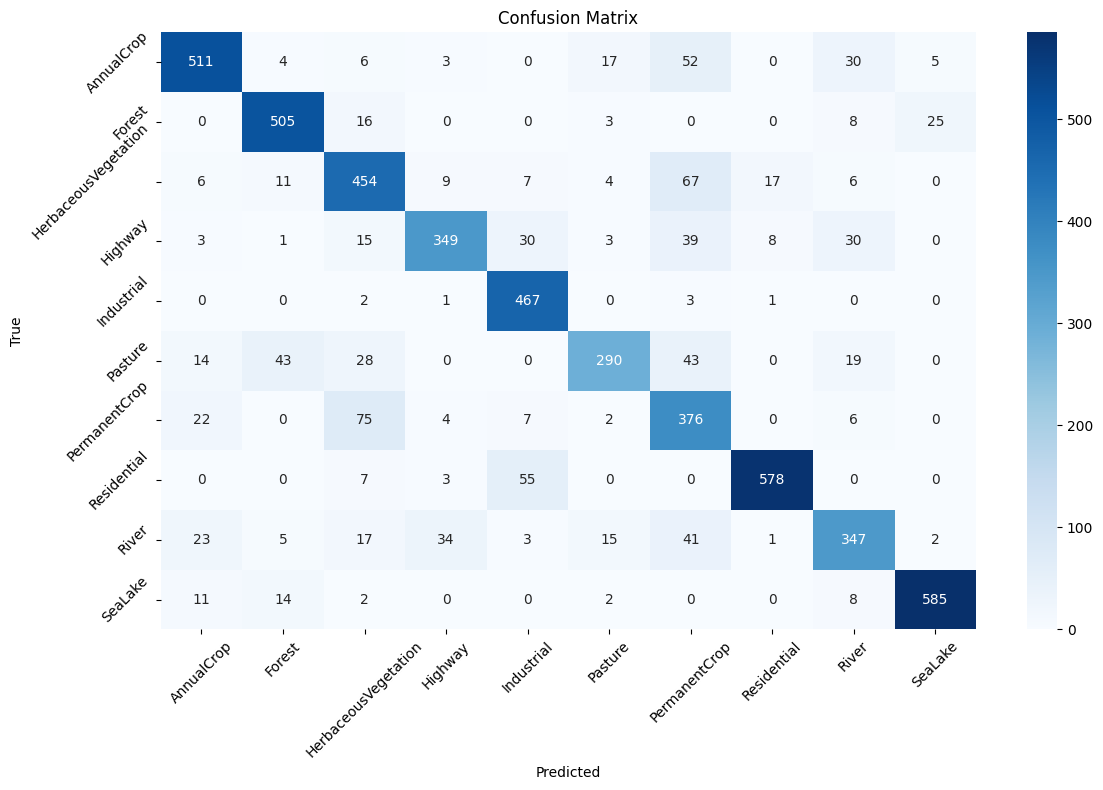


Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.87      0.81      0.84       628
              Forest       0.87      0.91      0.89       557
HerbaceousVegetation       0.73      0.78      0.75       581
             Highway       0.87      0.73      0.79       478
          Industrial       0.82      0.99      0.90       474
             Pasture       0.86      0.66      0.75       437
       PermanentCrop       0.61      0.76      0.68       492
         Residential       0.96      0.90      0.93       643
               River       0.76      0.71      0.74       488
             SeaLake       0.95      0.94      0.94       622

            accuracy                           0.83      5400
           macro avg       0.83      0.82      0.82      5400
        weighted avg       0.83      0.83      0.83      5400



In [ ]:
# 1. Train AlexNet from scratch

# Training configuration
num_classes = 10
learning_rate = 0.001
num_epochs = 25

alexnet_scratch = alexnet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet_scratch.parameters(), lr=learning_rate)
alexnet_scratch_results = train_model(alexnet_scratch, train_loader, test_loader, criterion, optimizer, num_epochs, device)

evaluate_model(alexnet_scratch, test_loader)
plot_training_curves(alexnet_scratch_results)

gc.collect()
torch.cuda.empty_cache()


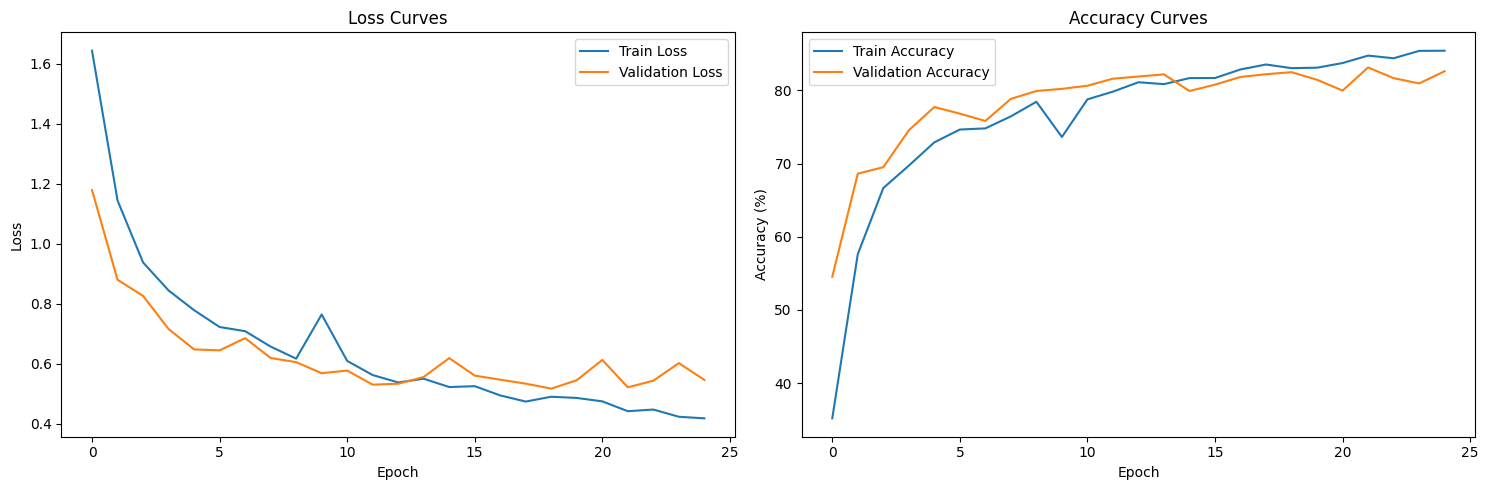

In [ ]:
plot_training_curves(alexnet_scratch_results)

Train MobileNet from Scratch

In [ ]:
# 2. Train MobileNetV2 from scratch

# Training configuration
num_classes = 10
learning_rate = 0.001
num_epochs = 25

mobilenet_scratch = mobilenet_v2(num_classes=num_classes).to(device)
optimizer = optim.Adam(mobilenet_scratch.parameters(), lr=learning_rate)
mobilenet_scratch_results = train_model(mobilenet_scratch, train_loader, test_loader, criterion, optimizer, num_epochs)

C:\Users\leole\AppData\Local\Temp\ipykernel_22972\303014655.py:30: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/25 [Train]:   0%|          | 0/675 [00:00<?, ?it/s]C:\Users\leole\AppData\Local\Temp\ipykernel_22972\303014655.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Improves memory efficiency
Epoch 1/25 [Val]: 100%|██████████| 169/169 [00:20<00:00,  8.24it/s]



Epoch 1/25:
Train Loss: 0.9616, Train Acc: 66.09%
Val Loss: 0.7013, Val Acc: 76.13%


Epoch 2/25 [Val]: 100%|██████████| 169/169 [00:19<00:00,  8.71it/s]



Epoch 2/25:
Train Loss: 0.6098, Train Acc: 79.14%
Val Loss: 0.4428, Val Acc: 84.76%


Epoch 3/25 [Val]: 100%|██████████| 169/169 [00:19<00:00,  8.69it/s]



Epoch 3/25:
Train Loss: 0.4611, Train Acc: 84.39%
Val Loss: 0.3669, Val Acc: 87.39%


Epoch 4/25 [Val]: 100%|██████████| 169/169 [00:19<00:00,  8.59it/s]



Epoch 4/25:
Train Loss: 0.3668, Train Acc: 87.68%
Val Loss: 0.3000, Val Acc: 89.37%


Epoch 5/25 [Val]: 100%|██████████| 169/169 [00:19<00:00,  8.58it/s]



Epoch 5/25:
Train Loss: 0.3053, Train Acc: 89.65%
Val Loss: 0.2395, Val Acc: 92.04%


Epoch 6/25 [Val]: 100%|██████████| 169/169 [00:19<00:00,  8.74it/s]



Epoch 6/25:
Train Loss: 0.2673, Train Acc: 91.25%
Val Loss: 0.2538, Val Acc: 91.37%


Epoch 7/25 [Val]: 100%|██████████| 169/169 [00:19<00:00,  8.74it/s]



Epoch 7/25:
Train Loss: 0.2325, Train Acc: 92.26%
Val Loss: 0.2689, Val Acc: 90.80%


Epoch 8/25 [Val]: 100%|██████████| 169/169 [00:19<00:00,  8.61it/s]



Epoch 8/25:
Train Loss: 0.2280, Train Acc: 92.14%
Val Loss: 0.2823, Val Acc: 91.48%


Epoch 9/25 [Val]: 100%|██████████| 169/169 [00:19<00:00,  8.73it/s]



Epoch 9/25:
Train Loss: 0.2061, Train Acc: 93.00%
Val Loss: 0.2562, Val Acc: 91.93%


Epoch 10/25 [Val]: 100%|██████████| 169/169 [00:19<00:00,  8.61it/s]



Epoch 10/25:
Train Loss: 0.1868, Train Acc: 93.73%
Val Loss: 0.1941, Val Acc: 93.46%


Epoch 11/25 [Val]: 100%|██████████| 169/169 [00:19<00:00,  8.78it/s]



Epoch 11/25:
Train Loss: 0.1644, Train Acc: 94.35%
Val Loss: 0.1468, Val Acc: 95.13%


Epoch 12/25 [Val]: 100%|██████████| 169/169 [00:19<00:00,  8.83it/s]



Epoch 12/25:
Train Loss: 0.1435, Train Acc: 95.06%
Val Loss: 0.2196, Val Acc: 92.80%


Epoch 13/25 [Val]: 100%|██████████| 169/169 [00:19<00:00,  8.78it/s]



Epoch 13/25:
Train Loss: 0.1456, Train Acc: 95.08%
Val Loss: 0.1943, Val Acc: 93.61%


Epoch 14/25 [Val]: 100%|██████████| 169/169 [00:19<00:00,  8.78it/s]



Epoch 14/25:
Train Loss: 0.1313, Train Acc: 95.33%
Val Loss: 0.1709, Val Acc: 94.06%


Epoch 15/25 [Val]: 100%|██████████| 169/169 [00:19<00:00,  8.81it/s]



Epoch 15/25:
Train Loss: 0.1225, Train Acc: 95.91%
Val Loss: 0.1330, Val Acc: 95.57%


Epoch 16/25 [Val]: 100%|██████████| 169/169 [00:19<00:00,  8.89it/s]



Epoch 16/25:
Train Loss: 0.1078, Train Acc: 96.25%
Val Loss: 0.1555, Val Acc: 94.83%


Epoch 17/25 [Val]: 100%|██████████| 169/169 [00:18<00:00,  8.91it/s]



Epoch 17/25:
Train Loss: 0.1031, Train Acc: 96.57%
Val Loss: 0.1681, Val Acc: 94.33%


Epoch 18/25 [Val]: 100%|██████████| 169/169 [00:19<00:00,  8.75it/s]



Epoch 18/25:
Train Loss: 0.1057, Train Acc: 96.42%
Val Loss: 0.1638, Val Acc: 94.54%


Epoch 19/25 [Val]: 100%|██████████| 169/169 [00:19<00:00,  8.73it/s]



Epoch 19/25:
Train Loss: 0.0911, Train Acc: 96.88%
Val Loss: 0.1865, Val Acc: 94.44%


Epoch 20/25 [Val]: 100%|██████████| 169/169 [00:20<00:00,  8.37it/s]



Epoch 20/25:
Train Loss: 0.0861, Train Acc: 97.07%
Val Loss: 0.1511, Val Acc: 95.07%


Epoch 21/25 [Val]: 100%|██████████| 169/169 [00:19<00:00,  8.75it/s]



Epoch 21/25:
Train Loss: 0.0763, Train Acc: 97.25%
Val Loss: 0.1990, Val Acc: 94.33%


Epoch 22/25 [Val]: 100%|██████████| 169/169 [00:19<00:00,  8.77it/s]



Epoch 22/25:
Train Loss: 0.0879, Train Acc: 96.89%
Val Loss: 0.1317, Val Acc: 96.07%


Epoch 23/25 [Val]: 100%|██████████| 169/169 [00:19<00:00,  8.63it/s]



Epoch 23/25:
Train Loss: 0.0746, Train Acc: 97.47%
Val Loss: 0.1519, Val Acc: 95.13%


Epoch 24/25 [Val]: 100%|██████████| 169/169 [00:19<00:00,  8.74it/s]



Epoch 24/25:
Train Loss: 0.0738, Train Acc: 97.38%
Val Loss: 0.3050, Val Acc: 91.33%


Epoch 25/25 [Val]: 100%|██████████| 169/169 [00:19<00:00,  8.50it/s]


Epoch 25/25:
Train Loss: 0.0643, Train Acc: 97.82%
Val Loss: 0.1506, Val Acc: 95.37%


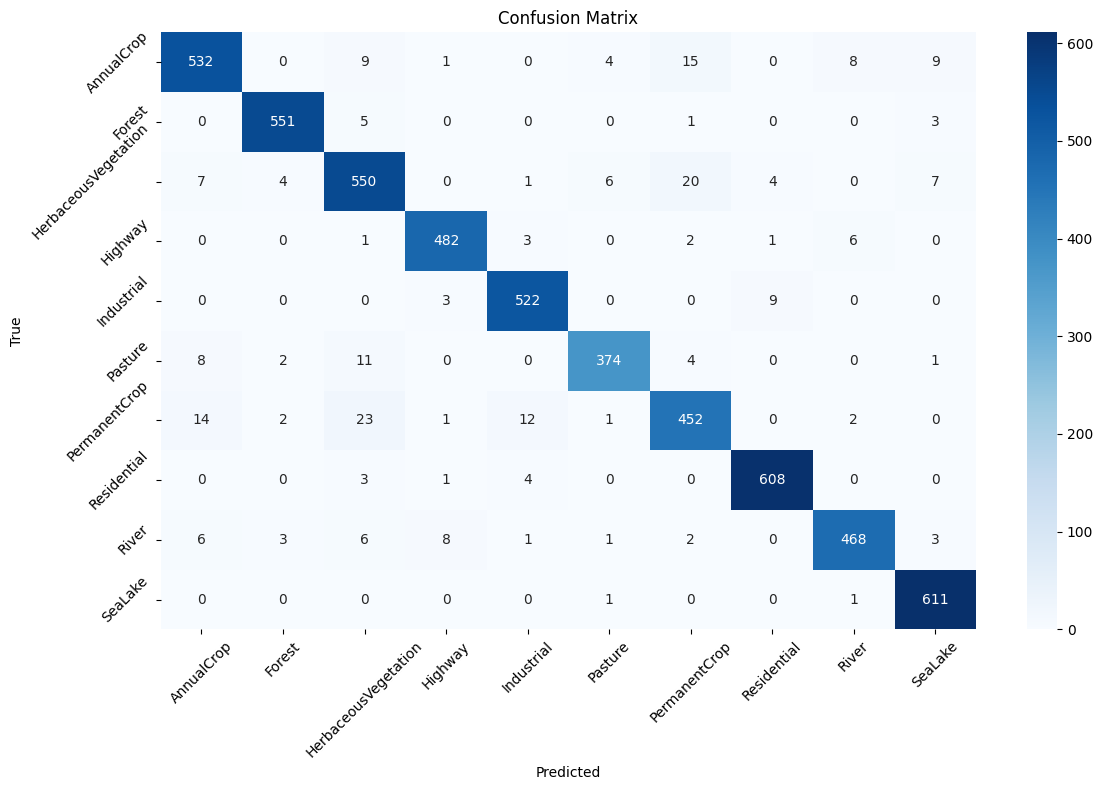


Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.94      0.92      0.93       578
              Forest       0.98      0.98      0.98       560
HerbaceousVegetation       0.90      0.92      0.91       599
             Highway       0.97      0.97      0.97       495
          Industrial       0.96      0.98      0.97       534
             Pasture       0.97      0.94      0.95       400
       PermanentCrop       0.91      0.89      0.90       507
         Residential       0.98      0.99      0.98       616
               River       0.96      0.94      0.95       498
             SeaLake       0.96      1.00      0.98       613

            accuracy                           0.95      5400
           macro avg       0.95      0.95      0.95      5400
        weighted avg       0.95      0.95      0.95      5400



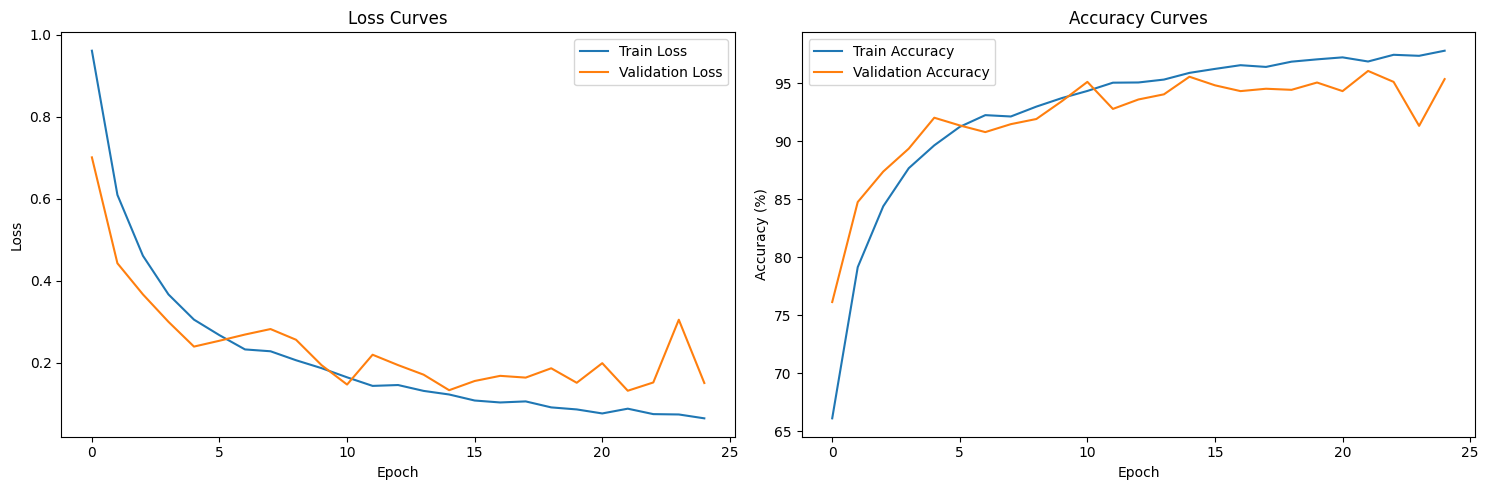

In [ ]:
evaluate_model(mobilenet_scratch, test_loader)
plot_training_curves(mobilenet_scratch_results)

gc.collect()
torch.cuda.empty_cache()

Train AlexNet with Pre Trained weights

In [ ]:
#Train AlexNet with Pre-trained weights

# Training configuration
num_classes = 10
learning_rate = 0.001
num_epochs = 25

alexnet_pretrained = alexnet(pretrained=True)

for param in alexnet_pretrained.features.parameters():
    param.requires_grad = False

criterion = nn.CrossEntropyLoss()
alexnet_pretrained.classifier[-1] = nn.Linear(4096, num_classes)
alexnet_pretrained = alexnet_pretrained.to(device)

optimizer = optim.Adam(alexnet_pretrained.parameters(), lr=learning_rate)
alexnet_pretrained_results = train_model(alexnet_pretrained,train_loader, val_loader, criterion, optimizer, num_epochs)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-4-51db932fc5fc>:30: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/25 [Train]:   0%|          | 0/675 [00:00<?, ?it/s]<ipython-input-4-51db932fc5fc>:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cu


Epoch 1/25:
Train Loss: 1.2270, Train Acc: 56.62%
Val Loss: 0.7778, Val Acc: 72.13%


Epoch 2/25 [Val]: 100%|██████████| 169/169 [00:03<00:00, 55.63it/s]



Epoch 2/25:
Train Loss: 0.8085, Train Acc: 73.38%
Val Loss: 0.5855, Val Acc: 80.83%


Epoch 3/25 [Val]: 100%|██████████| 169/169 [00:03<00:00, 54.89it/s]



Epoch 3/25:
Train Loss: 0.6460, Train Acc: 79.40%
Val Loss: 0.6638, Val Acc: 78.13%


Epoch 4/25 [Val]: 100%|██████████| 169/169 [00:03<00:00, 54.34it/s]



Epoch 4/25:
Train Loss: 0.5443, Train Acc: 82.60%
Val Loss: 0.6250, Val Acc: 80.93%


Epoch 5/25 [Val]: 100%|██████████| 169/169 [00:03<00:00, 54.65it/s]



Epoch 5/25:
Train Loss: 0.5331, Train Acc: 83.32%
Val Loss: 0.4443, Val Acc: 84.41%


Epoch 6/25 [Val]: 100%|██████████| 169/169 [00:03<00:00, 49.69it/s]



Epoch 6/25:
Train Loss: 0.4226, Train Acc: 86.56%
Val Loss: 0.3327, Val Acc: 89.59%


Epoch 7/25 [Val]: 100%|██████████| 169/169 [00:03<00:00, 54.32it/s]



Epoch 7/25:
Train Loss: 0.4346, Train Acc: 86.71%
Val Loss: 0.3929, Val Acc: 87.81%


Epoch 8/25 [Val]: 100%|██████████| 169/169 [00:03<00:00, 52.32it/s]



Epoch 8/25:
Train Loss: 0.3616, Train Acc: 88.60%
Val Loss: 0.4505, Val Acc: 86.41%


Epoch 9/25 [Val]: 100%|██████████| 169/169 [00:03<00:00, 55.04it/s]



Epoch 9/25:
Train Loss: 0.4511, Train Acc: 85.80%
Val Loss: 0.4533, Val Acc: 85.06%


Epoch 10/25 [Val]: 100%|██████████| 169/169 [00:03<00:00, 52.50it/s]



Epoch 10/25:
Train Loss: 0.3717, Train Acc: 88.45%
Val Loss: 0.3944, Val Acc: 88.31%


Epoch 11/25 [Val]: 100%|██████████| 169/169 [00:03<00:00, 55.54it/s]



Epoch 11/25:
Train Loss: 0.3362, Train Acc: 89.60%
Val Loss: 0.2932, Val Acc: 91.00%


Epoch 12/25 [Val]: 100%|██████████| 169/169 [00:03<00:00, 54.22it/s]



Epoch 12/25:
Train Loss: 0.3510, Train Acc: 89.30%
Val Loss: 0.3583, Val Acc: 88.83%


Epoch 13/25 [Val]: 100%|██████████| 169/169 [00:03<00:00, 55.19it/s]



Epoch 13/25:
Train Loss: 0.3415, Train Acc: 89.54%
Val Loss: 0.4277, Val Acc: 87.87%


Epoch 14/25 [Val]: 100%|██████████| 169/169 [00:03<00:00, 54.70it/s]



Epoch 14/25:
Train Loss: 0.3886, Train Acc: 88.38%
Val Loss: 0.2640, Val Acc: 91.81%


Epoch 15/25 [Val]: 100%|██████████| 169/169 [00:03<00:00, 55.07it/s]



Epoch 15/25:
Train Loss: 0.2938, Train Acc: 91.01%
Val Loss: 0.3259, Val Acc: 89.96%


Epoch 16/25 [Val]: 100%|██████████| 169/169 [00:03<00:00, 54.98it/s]



Epoch 16/25:
Train Loss: 0.2660, Train Acc: 91.87%
Val Loss: 0.4409, Val Acc: 88.57%


Epoch 17/25 [Val]: 100%|██████████| 169/169 [00:03<00:00, 54.71it/s]



Epoch 17/25:
Train Loss: 0.3155, Train Acc: 90.75%
Val Loss: 0.4940, Val Acc: 85.46%


Epoch 18/25 [Val]: 100%|██████████| 169/169 [00:03<00:00, 54.47it/s]



Epoch 18/25:
Train Loss: 0.3279, Train Acc: 90.52%
Val Loss: 0.2678, Val Acc: 92.54%


Epoch 19/25 [Val]: 100%|██████████| 169/169 [00:03<00:00, 55.17it/s]



Epoch 19/25:
Train Loss: 0.2774, Train Acc: 91.57%
Val Loss: 0.3578, Val Acc: 90.15%


Epoch 20/25 [Val]: 100%|██████████| 169/169 [00:03<00:00, 55.66it/s]



Epoch 20/25:
Train Loss: 0.4050, Train Acc: 87.99%
Val Loss: 0.4258, Val Acc: 89.80%


Epoch 21/25 [Val]: 100%|██████████| 169/169 [00:03<00:00, 53.88it/s]



Epoch 21/25:
Train Loss: 0.3147, Train Acc: 90.97%
Val Loss: 0.2848, Val Acc: 91.96%


Epoch 22/25 [Val]: 100%|██████████| 169/169 [00:03<00:00, 54.66it/s]



Epoch 22/25:
Train Loss: 0.3410, Train Acc: 89.63%
Val Loss: 0.6030, Val Acc: 81.85%


Epoch 23/25 [Val]: 100%|██████████| 169/169 [00:03<00:00, 51.78it/s]



Epoch 23/25:
Train Loss: 0.3424, Train Acc: 89.74%
Val Loss: 0.2300, Val Acc: 93.22%


Epoch 24/25 [Val]: 100%|██████████| 169/169 [00:03<00:00, 54.84it/s]



Epoch 24/25:
Train Loss: 0.3321, Train Acc: 90.52%
Val Loss: 0.2415, Val Acc: 92.94%


Epoch 25/25 [Val]: 100%|██████████| 169/169 [00:03<00:00, 52.03it/s]


Epoch 25/25:
Train Loss: 0.2879, Train Acc: 91.65%
Val Loss: 0.2637, Val Acc: 92.94%


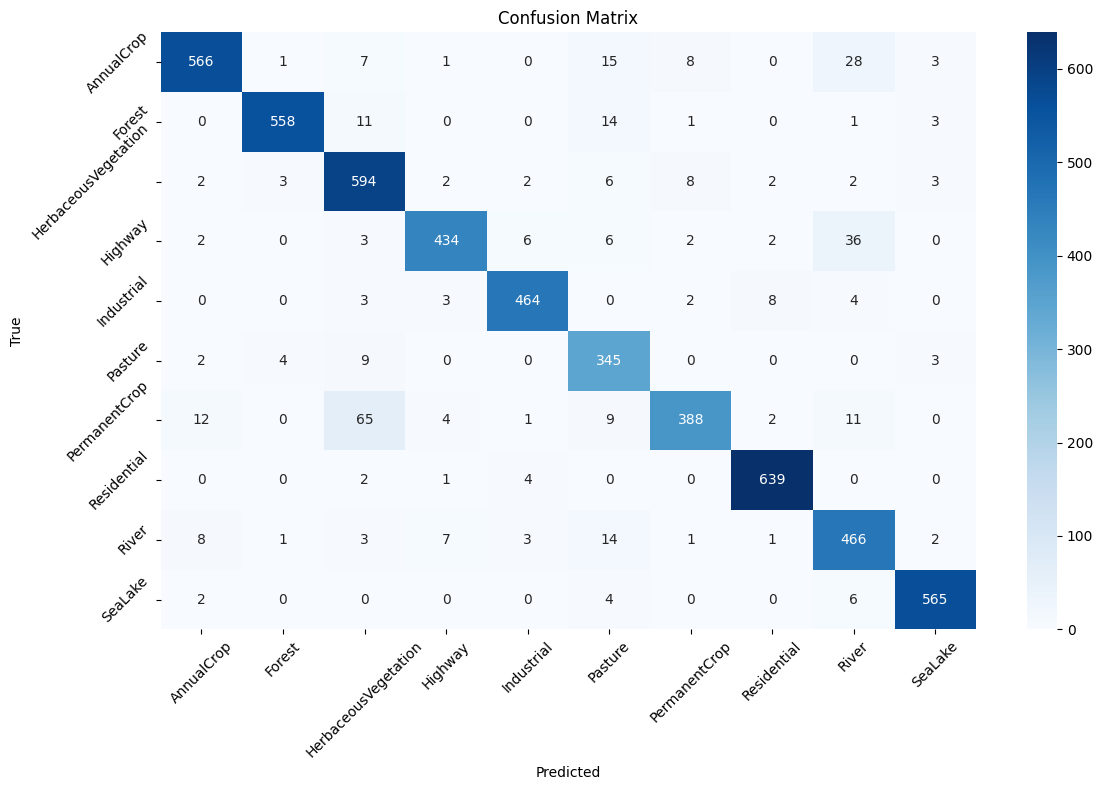


Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.95      0.90      0.93       629
              Forest       0.98      0.95      0.97       588
HerbaceousVegetation       0.85      0.95      0.90       624
             Highway       0.96      0.88      0.92       491
          Industrial       0.97      0.96      0.96       484
             Pasture       0.84      0.95      0.89       363
       PermanentCrop       0.95      0.79      0.86       492
         Residential       0.98      0.99      0.98       646
               River       0.84      0.92      0.88       506
             SeaLake       0.98      0.98      0.98       577

            accuracy                           0.93      5400
           macro avg       0.93      0.93      0.93      5400
        weighted avg       0.93      0.93      0.93      5400



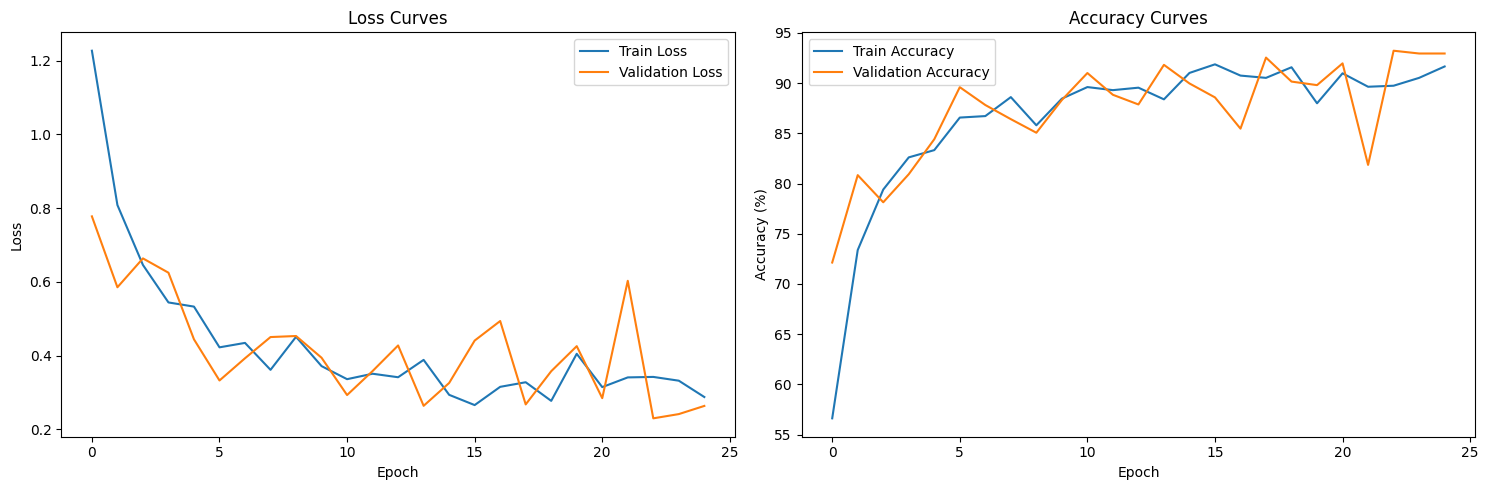

In [ ]:
evaluate_model(alexnet_pretrained, test_loader)
plot_training_curves(alexnet_pretrained_results)

gc.collect()
torch.cuda.empty_cache()

Train MobileNet with Pre Trained weights

In [ ]:
# Train Mobile Net with Pre-Trained Weights

# Training configuration
num_classes = 10
learning_rate = 0.001
num_epochs = 25

mobilenet_pretrained = mobilenet_v2(pretrained=True)

for param in mobilenet_pretrained.features.parameters():
    param.requires_grad = False

mobilenet_pretrained.classifier[-1] = nn.Linear(1280, num_classes)

mobilenet_pretrained = mobilenet_pretrained.to(device)

optimizer = optim.Adam(mobilenet_pretrained.parameters(), lr=learning_rate)
loss = nn.CrossEntropyLoss()
mobilenet_pretrained_results = train_model(mobilenet_pretrained, train_loader, val_loader, loss, optimizer, num_epochs, device)

<ipython-input-13-8a866b8947e5>:29: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/25 [Train]:   0%|          | 0/608 [00:00<?, ?it/s]<ipython-input-13-8a866b8947e5>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Improves memory efficiency
Epoch 1/25 [Val]: 100%|██████████| 68/68 [00:01<00:00, 40.51it/s]



Epoch 1/25:
Train Loss: 0.4884, Train Acc: 84.50%
Val Loss: 0.2479, Val Acc: 91.62%


Epoch 2/25 [Val]: 100%|██████████| 68/68 [00:01<00:00, 44.80it/s]



Epoch 2/25:
Train Loss: 0.3007, Train Acc: 89.60%
Val Loss: 0.2112, Val Acc: 92.73%


Epoch 3/25 [Val]: 100%|██████████| 68/68 [00:01<00:00, 44.79it/s]



Epoch 3/25:
Train Loss: 0.2798, Train Acc: 90.31%
Val Loss: 0.2001, Val Acc: 93.15%


Epoch 4/25 [Val]: 100%|██████████| 68/68 [00:01<00:00, 45.44it/s]



Epoch 4/25:
Train Loss: 0.2719, Train Acc: 90.53%
Val Loss: 0.1980, Val Acc: 93.06%


Epoch 5/25 [Val]: 100%|██████████| 68/68 [00:01<00:00, 42.38it/s]



Epoch 5/25:
Train Loss: 0.2629, Train Acc: 90.84%
Val Loss: 0.1883, Val Acc: 93.56%


Epoch 6/25 [Val]: 100%|██████████| 68/68 [00:01<00:00, 44.80it/s]



Epoch 6/25:
Train Loss: 0.2597, Train Acc: 90.86%
Val Loss: 0.1734, Val Acc: 93.98%


Epoch 7/25 [Val]: 100%|██████████| 68/68 [00:01<00:00, 44.83it/s]



Epoch 7/25:
Train Loss: 0.2483, Train Acc: 91.33%
Val Loss: 0.1738, Val Acc: 93.94%


Epoch 8/25 [Val]: 100%|██████████| 68/68 [00:01<00:00, 41.98it/s]



Epoch 8/25:
Train Loss: 0.2532, Train Acc: 91.01%
Val Loss: 0.1955, Val Acc: 93.06%


Epoch 9/25 [Val]: 100%|██████████| 68/68 [00:01<00:00, 43.96it/s]



Epoch 9/25:
Train Loss: 0.2524, Train Acc: 91.24%
Val Loss: 0.1671, Val Acc: 94.17%


Epoch 10/25 [Val]: 100%|██████████| 68/68 [00:01<00:00, 45.06it/s]



Epoch 10/25:
Train Loss: 0.2451, Train Acc: 91.39%
Val Loss: 0.1684, Val Acc: 94.17%


Epoch 11/25 [Val]: 100%|██████████| 68/68 [00:01<00:00, 45.72it/s]



Epoch 11/25:
Train Loss: 0.2495, Train Acc: 91.21%
Val Loss: 0.1681, Val Acc: 94.21%


Epoch 12/25 [Val]: 100%|██████████| 68/68 [00:01<00:00, 44.78it/s]



Epoch 12/25:
Train Loss: 0.2502, Train Acc: 91.35%
Val Loss: 0.1790, Val Acc: 93.75%


Epoch 13/25 [Val]: 100%|██████████| 68/68 [00:01<00:00, 41.73it/s]



Epoch 13/25:
Train Loss: 0.2460, Train Acc: 91.48%
Val Loss: 0.1749, Val Acc: 93.98%


Epoch 14/25 [Val]: 100%|██████████| 68/68 [00:01<00:00, 44.52it/s]



Epoch 14/25:
Train Loss: 0.2403, Train Acc: 91.44%
Val Loss: 0.1626, Val Acc: 94.26%


Epoch 15/25 [Val]: 100%|██████████| 68/68 [00:01<00:00, 44.29it/s]



Epoch 15/25:
Train Loss: 0.2458, Train Acc: 91.52%
Val Loss: 0.1683, Val Acc: 94.12%


Epoch 16/25 [Val]: 100%|██████████| 68/68 [00:01<00:00, 43.09it/s]



Epoch 16/25:
Train Loss: 0.2479, Train Acc: 91.27%
Val Loss: 0.1657, Val Acc: 93.98%


Epoch 17/25 [Val]: 100%|██████████| 68/68 [00:01<00:00, 44.75it/s]



Epoch 17/25:
Train Loss: 0.2403, Train Acc: 91.41%
Val Loss: 0.1740, Val Acc: 93.75%


Epoch 18/25 [Val]: 100%|██████████| 68/68 [00:01<00:00, 41.74it/s]



Epoch 18/25:
Train Loss: 0.2439, Train Acc: 91.73%
Val Loss: 0.1799, Val Acc: 93.47%


Epoch 19/25 [Val]: 100%|██████████| 68/68 [00:01<00:00, 44.56it/s]



Epoch 19/25:
Train Loss: 0.2441, Train Acc: 91.56%
Val Loss: 0.1763, Val Acc: 93.89%


Epoch 20/25 [Val]: 100%|██████████| 68/68 [00:01<00:00, 41.69it/s]



Epoch 20/25:
Train Loss: 0.2359, Train Acc: 91.88%
Val Loss: 0.1601, Val Acc: 94.77%


Epoch 21/25 [Val]: 100%|██████████| 68/68 [00:01<00:00, 43.90it/s]



Epoch 21/25:
Train Loss: 0.2423, Train Acc: 91.60%
Val Loss: 0.1689, Val Acc: 94.26%


Epoch 22/25 [Val]: 100%|██████████| 68/68 [00:01<00:00, 43.73it/s]



Epoch 22/25:
Train Loss: 0.2446, Train Acc: 91.63%
Val Loss: 0.1889, Val Acc: 93.47%


Epoch 23/25 [Val]: 100%|██████████| 68/68 [00:01<00:00, 40.26it/s]



Epoch 23/25:
Train Loss: 0.2442, Train Acc: 91.68%
Val Loss: 0.1852, Val Acc: 93.43%


Epoch 24/25 [Val]: 100%|██████████| 68/68 [00:01<00:00, 44.18it/s]



Epoch 24/25:
Train Loss: 0.2363, Train Acc: 91.80%
Val Loss: 0.1810, Val Acc: 93.94%


Epoch 25/25 [Val]: 100%|██████████| 68/68 [00:01<00:00, 45.28it/s]


Epoch 25/25:
Train Loss: 0.2514, Train Acc: 91.42%
Val Loss: 0.1669, Val Acc: 94.40%


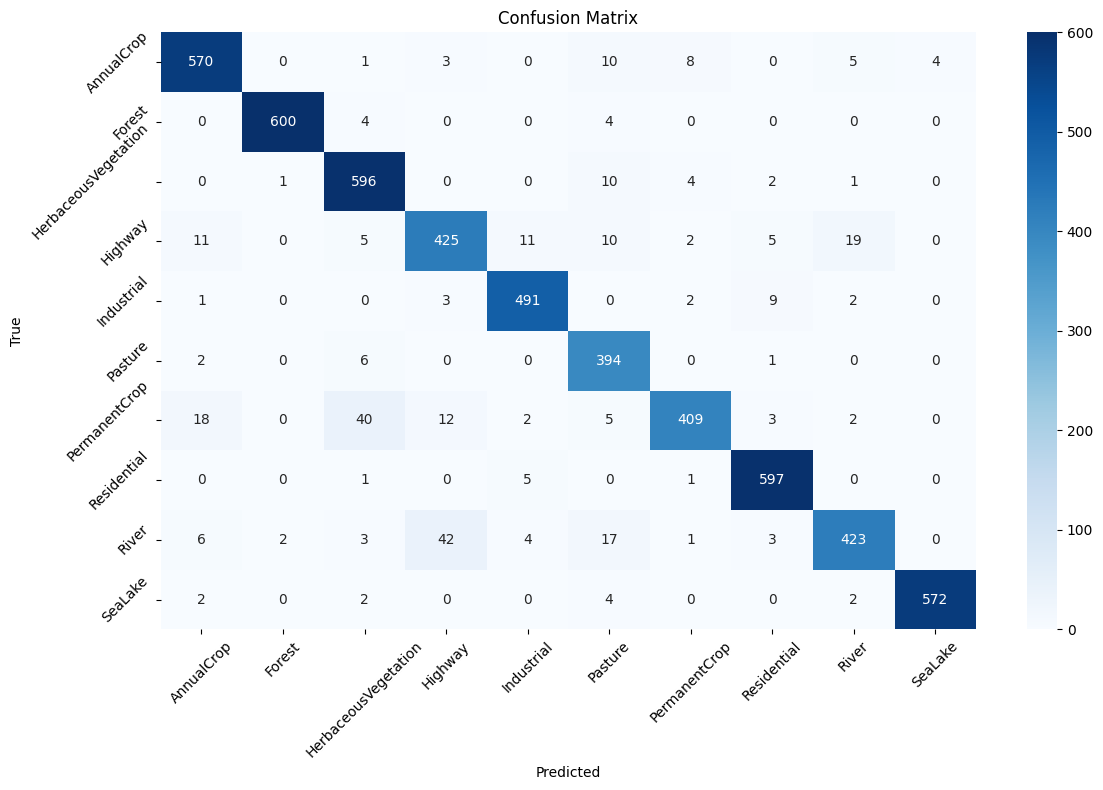


Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.93      0.95      0.94       601
              Forest       1.00      0.99      0.99       608
HerbaceousVegetation       0.91      0.97      0.94       614
             Highway       0.88      0.87      0.87       488
          Industrial       0.96      0.97      0.96       508
             Pasture       0.87      0.98      0.92       403
       PermanentCrop       0.96      0.83      0.89       491
         Residential       0.96      0.99      0.98       604
               River       0.93      0.84      0.89       501
             SeaLake       0.99      0.98      0.99       582

            accuracy                           0.94      5400
           macro avg       0.94      0.94      0.94      5400
        weighted avg       0.94      0.94      0.94      5400



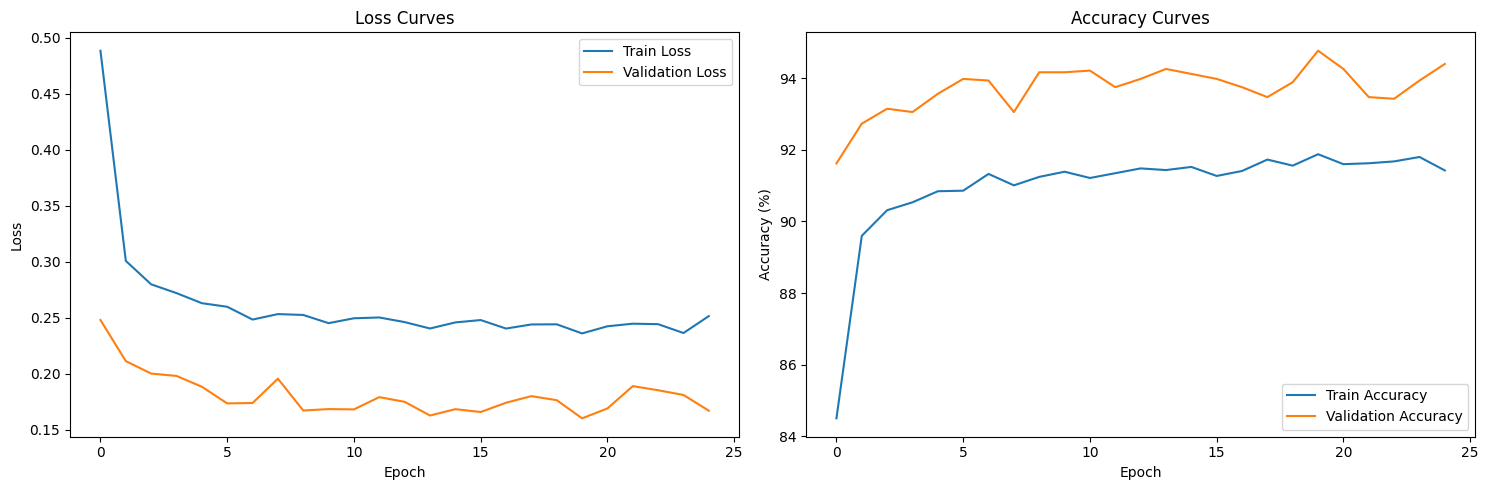

In [ ]:
evaluate_model(mobilenet_pretrained, test_loader, class_names)
plot_training_curves(mobilenet_pretrained_results)

gc.collect()
torch.cuda.empty_cache()

### Fusion Network

In [ ]:
class MiddleFusionModel(nn.Module):
    def __init__(self, num_classes=1000):
        super(MiddleFusionModel, self).__init__()

        # Load pre-trained models
        self.alexnet = alexnet(pretrained=True)
        self.mobilenet = mobilenet_v2(pretrained=True)

        # Remove the original classifier layers
        self.alexnet_features = nn.Sequential(*list(self.alexnet.features.children()))
        self.mobilenet_features = nn.Sequential(*list(self.mobilenet.features.children()))

        # Calculate the concatenated feature dimensions
        # AlexNet features: 256 x 6 x 6
        # MobileNetV2 features: 1280 x 7 x 7
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        # Fusion layer (concatenated features)
        concat_features = 256 + 1280  # Feature channels from both networks

        # New classifier for the fused features
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(concat_features * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, num_classes)
        )

        # Freeze the pre-trained weights
        for param in self.alexnet_features.parameters():
            param.requires_grad = False
        for param in self.mobilenet_features.parameters():
            param.requires_grad = False

    def forward(self, x):
        # Extract features from both networks
        alex_features = self.alexnet_features(x)
        mobile_features = self.mobilenet_features(x)

        # Adjust spatial dimensions to match
        mobile_features = self.avgpool(mobile_features)

        # Concatenate features along the channel dimension
        combined_features = torch.cat((alex_features, mobile_features), dim=1)

        # Flatten the features
        combined_features = combined_features.view(combined_features.size(0), -1)

        # Pass through the new classifier
        output = self.classifier(combined_features)

        return output

In [ ]:
# Train Fusion Modle
num_classes = 10
learning_rate = 0.001
num_epochs = 25



FusionModel = MiddleFusionModel(num_classes)
FusionModel = FusionModel.to(device)

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(FusionModel.parameters(), lr=learning_rate)


FusionModel_results = train_model(FusionModel, train_loader, val_loader, loss, optimizer, num_epochs, device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-dat


Epoch 1/25:
Train Loss: 1.5795, Train Acc: 76.90%
Val Loss: 0.3028, Val Acc: 89.72%


Epoch 2/25 [Val]: 100%|██████████| 68/68 [00:05<00:00, 12.54it/s]



Epoch 2/25:
Train Loss: 0.4338, Train Acc: 86.09%
Val Loss: 0.2450, Val Acc: 93.24%


Epoch 3/25 [Val]: 100%|██████████| 68/68 [00:05<00:00, 13.12it/s]



Epoch 3/25:
Train Loss: 0.3812, Train Acc: 88.06%
Val Loss: 0.1928, Val Acc: 93.75%


Epoch 4/25 [Val]: 100%|██████████| 68/68 [00:05<00:00, 12.13it/s]



Epoch 4/25:
Train Loss: 0.3673, Train Acc: 88.80%
Val Loss: 0.2094, Val Acc: 93.89%


Epoch 5/25 [Val]: 100%|██████████| 68/68 [00:05<00:00, 12.91it/s]



Epoch 5/25:
Train Loss: 0.3375, Train Acc: 89.98%
Val Loss: 0.2217, Val Acc: 93.98%


Epoch 6/25 [Val]: 100%|██████████| 68/68 [00:05<00:00, 12.73it/s]



Epoch 6/25:
Train Loss: 0.3049, Train Acc: 90.90%
Val Loss: 0.2115, Val Acc: 93.70%


Epoch 7/25 [Val]: 100%|██████████| 68/68 [00:05<00:00, 11.93it/s]



Epoch 7/25:
Train Loss: 0.3043, Train Acc: 91.06%
Val Loss: 0.2052, Val Acc: 93.61%


Epoch 8/25 [Val]: 100%|██████████| 68/68 [00:06<00:00, 10.76it/s]



Epoch 8/25:
Train Loss: 0.2883, Train Acc: 91.16%
Val Loss: 0.1994, Val Acc: 93.94%


Epoch 9/25 [Val]: 100%|██████████| 68/68 [00:07<00:00,  8.97it/s]



Epoch 9/25:
Train Loss: 0.2737, Train Acc: 91.96%
Val Loss: 0.1873, Val Acc: 94.31%


Epoch 10/25 [Val]: 100%|██████████| 68/68 [00:06<00:00,  9.83it/s]



Epoch 10/25:
Train Loss: 0.2642, Train Acc: 92.17%
Val Loss: 0.1680, Val Acc: 95.28%


Epoch 11/25 [Val]: 100%|██████████| 68/68 [00:05<00:00, 12.51it/s]



Epoch 11/25:
Train Loss: 0.2477, Train Acc: 93.07%
Val Loss: 0.1748, Val Acc: 94.58%


Epoch 12/25 [Val]: 100%|██████████| 68/68 [00:05<00:00, 11.96it/s]



Epoch 12/25:
Train Loss: 0.2459, Train Acc: 93.00%
Val Loss: 0.1793, Val Acc: 94.58%


Epoch 13/25 [Val]: 100%|██████████| 68/68 [00:05<00:00, 12.86it/s]



Epoch 13/25:
Train Loss: 0.2533, Train Acc: 92.61%
Val Loss: 0.1829, Val Acc: 94.40%


Epoch 14/25 [Val]: 100%|██████████| 68/68 [00:05<00:00, 12.90it/s]



Epoch 14/25:
Train Loss: 0.2499, Train Acc: 93.08%
Val Loss: 0.1693, Val Acc: 95.05%


Epoch 15/25 [Val]: 100%|██████████| 68/68 [00:05<00:00, 13.04it/s]



Epoch 15/25:
Train Loss: 0.2402, Train Acc: 93.13%
Val Loss: 0.1847, Val Acc: 95.00%


Epoch 16/25 [Val]: 100%|██████████| 68/68 [00:05<00:00, 12.81it/s]



Epoch 16/25:
Train Loss: 0.2407, Train Acc: 93.11%
Val Loss: 0.1781, Val Acc: 94.63%


Epoch 17/25 [Val]: 100%|██████████| 68/68 [00:05<00:00, 12.59it/s]



Epoch 17/25:
Train Loss: 0.2086, Train Acc: 93.96%
Val Loss: 0.1779, Val Acc: 94.58%


Epoch 18/25 [Val]: 100%|██████████| 68/68 [00:06<00:00, 11.11it/s]



Epoch 18/25:
Train Loss: 0.2104, Train Acc: 93.79%
Val Loss: 0.1692, Val Acc: 94.63%


Epoch 19/25 [Val]: 100%|██████████| 68/68 [00:07<00:00,  9.40it/s]



Epoch 19/25:
Train Loss: 0.1954, Train Acc: 94.32%
Val Loss: 0.1671, Val Acc: 95.19%


Epoch 20/25 [Val]: 100%|██████████| 68/68 [00:07<00:00,  9.47it/s]



Epoch 20/25:
Train Loss: 0.2234, Train Acc: 93.86%
Val Loss: 0.1765, Val Acc: 94.91%


Epoch 21/25 [Val]: 100%|██████████| 68/68 [00:05<00:00, 12.65it/s]



Epoch 21/25:
Train Loss: 0.2203, Train Acc: 93.94%
Val Loss: 0.1758, Val Acc: 94.49%


Epoch 22/25 [Val]: 100%|██████████| 68/68 [00:05<00:00, 12.64it/s]



Epoch 22/25:
Train Loss: 0.2060, Train Acc: 94.02%
Val Loss: 0.1816, Val Acc: 94.26%


Epoch 23/25 [Val]: 100%|██████████| 68/68 [00:05<00:00, 12.87it/s]



Epoch 23/25:
Train Loss: 0.1945, Train Acc: 94.48%
Val Loss: 0.1724, Val Acc: 95.09%


Epoch 24/25 [Val]: 100%|██████████| 68/68 [00:05<00:00, 12.98it/s]



Epoch 24/25:
Train Loss: 0.1936, Train Acc: 94.43%
Val Loss: 0.1627, Val Acc: 95.51%


Epoch 25/25 [Val]: 100%|██████████| 68/68 [00:05<00:00, 12.55it/s]


Epoch 25/25:
Train Loss: 0.1898, Train Acc: 94.57%
Val Loss: 0.1743, Val Acc: 94.95%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


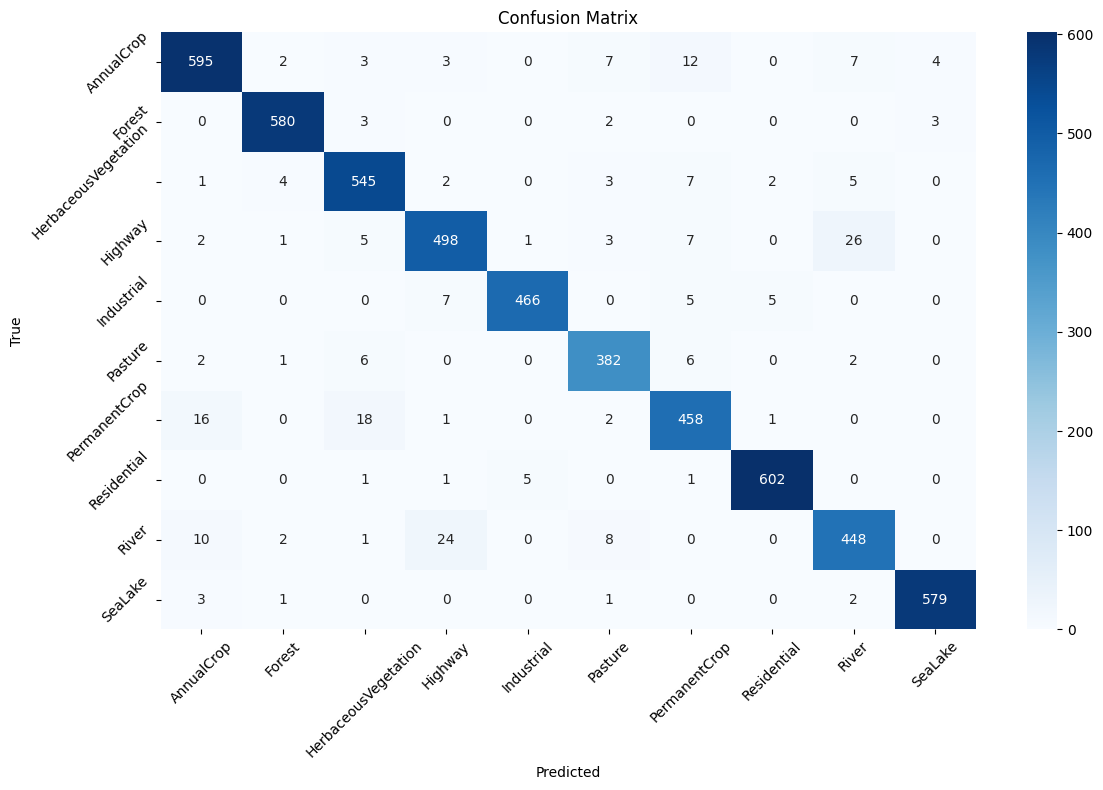


Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.95      0.94      0.94       633
              Forest       0.98      0.99      0.98       588
HerbaceousVegetation       0.94      0.96      0.95       569
             Highway       0.93      0.92      0.92       543
          Industrial       0.99      0.96      0.98       483
             Pasture       0.94      0.96      0.95       399
       PermanentCrop       0.92      0.92      0.92       496
         Residential       0.99      0.99      0.99       610
               River       0.91      0.91      0.91       493
             SeaLake       0.99      0.99      0.99       586

            accuracy                           0.95      5400
           macro avg       0.95      0.95      0.95      5400
        weighted avg       0.95      0.95      0.95      5400



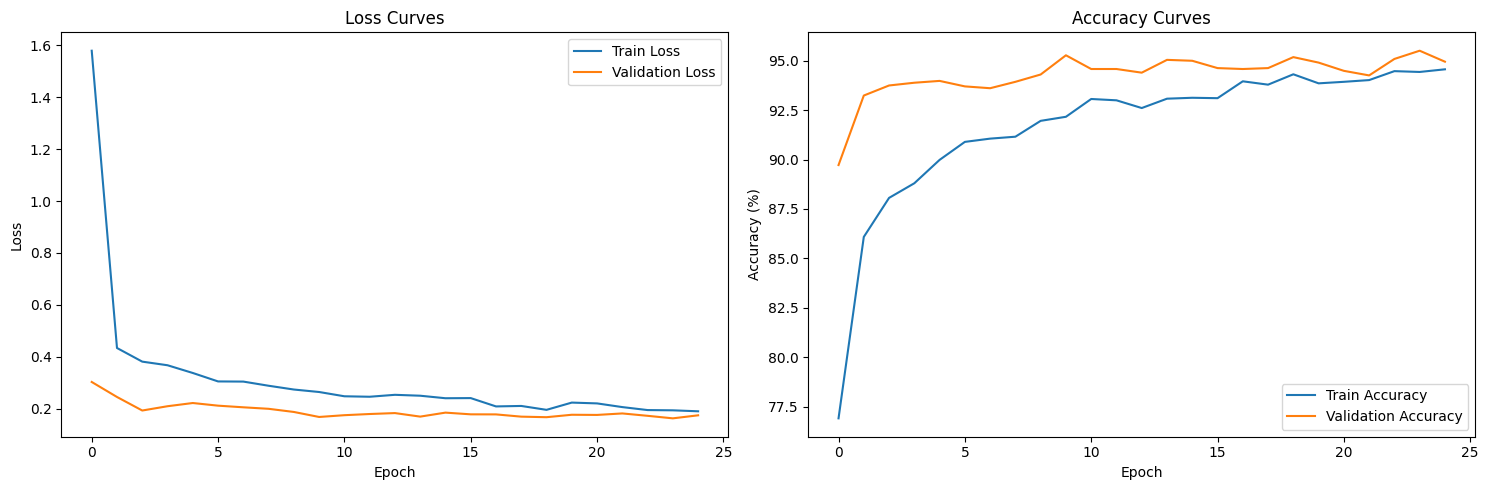

In [ ]:
evaluate_model(FusionModel, test_loader, class_names)
plot_training_curves(FusionModel_results)

gc.collect()
torch.cuda.empty_cache()